# Mirisha Suchde 
## MSc Finance
## 11289064
#
# Code for supervised project titled 
# "Inflation Effect on Corporate Capital Investment, a Replication Study."

## Importing Packages

In [1]:
# Importing the necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import plotly.express as px
import seaborn as sns

from scipy.stats import ttest_ind
from tabulate import tabulate
from scipy.stats.mstats import winsorize
from linearmodels.panel import PanelOLS
from linearmodels.panel import compare
from collections import OrderedDict
from statsmodels.stats.diagnostic import het_breuschpagan

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

/Users/Mirisha/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/Users/Mirisha/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


## Data Cleaning

In [2]:
# Reading the data file
data = pd.read_csv('data v4.csv', parse_dates = ['datadate'])
# Choosing only US-based firms
data = data[data['loc'] =='USA']
data.dropna(axis=0, how='any', inplace=True)
data

gvkey   datadate  fyear indfmt consol popsrc datafmt   tic  \
0         1004 2002-05-31   2001   INDL      C      D     STD   AIR   
1         1004 2003-05-31   2002   INDL      C      D     STD   AIR   
2         1004 2004-05-31   2003   INDL      C      D     STD   AIR   
3         1004 2005-05-31   2004   INDL      C      D     STD   AIR   
4         1004 2006-05-31   2005   INDL      C      D     STD   AIR   
...        ...        ...    ...    ...    ...    ...     ...   ...   
216832  345980 2021-12-31   2021   INDL      C      D     STD  WISH   
216835  347007 2021-12-31   2021   INDL      C      D     STD  IBRX   
216845  349972 2021-12-31   2021   INDL      C      D     STD  INDP   
216849  351038 2020-12-31   2020   INDL      C      D     STD  QNRX   
216850  351038 2021-12-31   2021   INDL      C      D     STD  QNRX   

                             conm acctstd  ...    icapt     invt  itcb  itci  \
0                        AAR CORP      DS  ...  527.934  286.588   0.0   0.0   
1                        AAR CORP      DS  ...  459.646  259.954   0.0   0.0   
2                        AAR CORP      DS  ...  550.350  247.245   0.0   0.0   
3                        AAR CORP      DS  ...  541.903  255.477   0.0   0.0   
4                        AAR CORP      DS  ...  741.293  323.592   0.0   0.0   
...                           ...     ...  ...      ...      ...   ...   ...   
216832           CONTEXTLOGIC INC      DS  ...  834.000    0.000   0.0   0.0   
216835            IMMUNITYBIO INC      DS  ...   99.504    0.000   0.0   0.0   
216845  INDAPTUS THERAPEUTICS INC      DS  ...   35.973    0.000   0.0   0.0   
216849  CELLECT BIOTECHNOLOGY LTD      DU  ...   -6.607    0.000   0.0   0.0   
216850  CELLECT BIOTECHNOLOGY LTD      DU  ...    0.657    0.000   0.0   0.0   

        lifr      revt  txfed  costat  loc   sic  
0        0.0   638.721 -2.832       A  USA  5080  
1        0.0   606.337  0.293       A  USA  5080  
2        0.0   651.958  1.329       A  USA  5080  
3        0.0   747.848  1.034       A  USA  5080  
4        0.0   897.284  1.355       A  USA  5080  
...      ...       ...    ...     ...  ...   ...  
216832   0.0  2085.000  0.000       A  USA  5961  
216835   0.0     0.934  0.000       A  USA  2836  
216845   0.0     0.000  0.000       A  USA  2836  
216849   0.0     0.000  0.000       A  USA  2834  
216850   0.0     0.000  0.000       A  USA  2834  

[64617 rows x 30 columns]

In [3]:
# Defining a function for classifying companies into 17 Fama-French Industries based in SIC codes
def classify_industry(sic_code):
    food_ranges = [
        [100, 199], [200, 299], [700, 799], [900, 999], [2000, 2009], [2010, 2019],
        [2020, 2029], [2030, 2039], [2040, 2046], [2047, 2047], [2048, 2048],
        [2050, 2059], [2060, 2063], [2064, 2068], [2070, 2079], [2080, 2080],
        [2082, 2082], [2083, 2083], [2084, 2084], [2085, 2085], [2086, 2086],
        [2087, 2087], [2090, 2092], [2095, 2095], [2096, 2096], [2097, 2097],
        [2098, 2099], [5140, 5149], [5150, 5159], [5180, 5182], [5191, 5191]
    ]

    mines_ranges = [
        [1000, 1009], [1010, 1019], [1020, 1029], [1030, 1039], [1040, 1049],
        [1060, 1069], [1080, 1089], [1090, 1099], [1200, 1299], [1400, 1499],
        [5050, 5052]
    ]
    
    oil_ranges = [
        [1300, 1300], [1310, 1319], [1320, 1329], [1380, 1380], [1381, 1381], 
        [1382, 1382], [1389, 1389], [2900, 2912], [5170, 5172]
    ]
    
    clothes_ranges = [
        [2200, 2269], [2270, 2279], [2280, 2284], [2290, 2295], [2296, 2296], 
        [2297, 2297], [2298, 2298], [2299, 2299], [2300, 2390], [2391, 2392], 
        [2393, 2395], [2396, 2396], [2397, 2399], [3020, 3021], [3100, 3111], 
        [3130, 3131], [3140, 3149], [3150, 3151], [3963, 3965], [5130, 5139]
    ]
    
    durables_ranges = [
        [2510, 2519], [2590, 2599], [3060, 3069], [3070, 3079], [3080, 3089], 
        [3090, 3099], [3630, 3639], [3650, 3651], [3652, 3652], [3860, 3861], 
        [3870, 3873], [3910, 3911], [3914, 3914], [3915, 3915], [3930, 3931], 
        [3940, 3949], [3960, 3962], [5020, 5023], [5064, 5064], [5094, 5094], 
        [5099, 5099]
    ]
    
    chemical_ranges = [
        [2800, 2809], [2810, 2819], [2820, 2829], [2860, 2869], [2870, 2879], 
        [2890, 2899], [5160, 5169]
    ]
    
    consumer_ranges = [
        [2100, 2199], [2830, 2830], [2831, 2831], [2833, 2833], [2834, 2834], 
        [2840, 2843], [2844, 2844], [5120, 5122], [5194, 5194]
    ]
    
    construction_ranges = [
        [800, 899], [1500, 1511], [1520, 1529], [1530, 1539], [1540, 1549], 
        [1600, 1699], [1700, 1799], [2400, 2439], [2440, 2449], [2450, 2459], 
        [2490 ,2499], [2850, 2859], [2950, 2952], [3200, 3200], [3210, 3211],
        [3240, 3241], [3250, 3259], [3261, 3261], [3264, 3264], [3270, 3275],
        [3280, 3281], [3290, 3293], [3420, 3429], [3430, 3433], [3440, 3441],
        [3442, 3442], [3446, 3446], [3448, 3448], [3449, 3449], [3450, 3451], 
        [3452, 3452], [5030, 5039], [5070, 5078], [5198, 5198], [5210, 5211],
        [5230, 5231], [5250, 5251]
    ]
    
    steel_ranges= [
        [3300, 3300], [3310, 3317], [3320, 3325], [3330, 3339], [3340, 3341], 
        [3350, 3357], [3360, 3369], [3390, 3399]
    ]
    
    fab_ranges= [ 
        [3410, 3412], [3443, 3443], [3444, 3444], [3460, 3469], [3470, 3479], 
        [3480, 3489], [3490, 3499]
    ]
    
    machinery_ranges = [
        [3510, 3519], [3520, 3529], [3530, 3530], [3531, 3531], [3532, 3532], 
        [3533, 3533], [3534, 3534], [3535, 3535], [3536, 3536], [3540, 3549], 
        [3550, 3559], [3560, 3569], [3570, 3579], [3580, 3580], [3581, 3581], 
        [3582, 3582], [3585, 3585], [3586, 3586], [3589, 3589], [3590, 3599], 
        [3600, 3600], [3610, 3613], [3620, 3621], [3622, 3622], [3623, 3629], 
        [3670, 3679], [3680, 3680], [3681, 3681], [3682, 3682], [3683, 3683], 
        [3684, 3684], [3685, 3685], [3686, 3686], [3687, 3687], [3688, 3688], 
        [3689, 3689], [3690, 3690], [3691, 3692], [3693, 3693], [3694, 3694],
        [3695, 3695], [3699, 3699], [3810, 3810], [3811, 3811], [3812, 3812], 
        [3820, 3820], [3821, 3821], [3822, 3822], [3823, 3823], [3824, 3824], 
        [3825, 3825], [3826, 3826], [3827, 3827], [3829, 3829], [3830, 3839], 
        [3950, 3955], [5060, 5060], [5063, 5063], [5065, 5065], [5080, 5080], 
        [5081, 5081]
    ]

    
    auto_ranges = [
        [3710, 3710], [3711, 3711], [3714, 3714], [3716, 3716], [3750, 3751],
        [3792, 3792], [5010, 5015], [5510, 5521], [5530, 5531], [5560, 5561],
        [5570, 5571], [5590, 5599]
    ]
    
    transportation_ranges = [
        [3713, 3713], [3715, 3715], [3720, 3720], [3721, 3721], [3724, 3724],
        [3725, 3725], [3728, 3728], [3730, 3731], [3732, 3732], [3740, 3743],
        [3760, 3769], [3790, 3790], [3795, 3795], [3799, 3799], [4000, 4013],
        [4100, 4100], [4110, 4119], [4120, 4121], [4130, 4131], [4140, 4142],
        [4150, 4151], [4170, 4173], [4190, 4199], [4200, 4200], [4210, 4219],
        [4220, 4229], [4230, 4231], [4400, 4499], [4500, 4599], [4600, 4699],
        [4700, 4700], [4710, 4712], [4720, 4729], [4730, 4739], [4740, 4742],
        [4780, 4780], [4783, 4783], [4785, 4785], [4789, 4789]
    ]
    
    util_ranges = [
        [4900, 4900], [4910, 4911], [4920, 4922], [4923, 4923], [4924, 4925], 
        [4930, 4931], [4932, 4932], [4939, 4939], [4940, 4942]
    ]
    
    retail_ranges = [
        [5260, 5261], [5270, 5271], [5300, 5300], [5310, 5311], 
        [5320, 5320], [5330, 5331], [5334, 5334], [5390, 5399], 
        [5400, 5400], [5410, 5411], [5412, 5412], [5420, 5421], 
        [5430, 5431], [5440, 5441], [5450, 5451], [5460, 5461], 
        [5490, 5499], [5540, 5541], [5550, 5551], [5600, 5699], 
        [5700, 5700], [5710, 5719], [5720, 5722], [5730, 5733], 
        [5734, 5734], [5735, 5735], [5736, 5736], [5750, 5750], 
        [5800, 5813], [5890, 5890], [5900, 5900], [5910, 5912], 
        [5920, 5921], [5930, 5932], [5940, 5940], [5941, 5941], 
        [5942, 5942], [5943, 5943], [5944, 5944], [5945, 5945], 
        [5946, 5946], [5947, 5947], [5948, 5948], [5949, 5949], 
        [5960, 5963], [5980, 5989], [5990, 5990], [5992, 5992], 
        [5993, 5993], [5994, 5994], [5995, 5995], [5999, 5999]
    ]

    finance_ranges = [
        [6010, 6019], [6020, 6020], [6021, 6021], [6022, 6022], [6023, 6023],
        [6025, 6025], [6026, 6026], [6028, 6029], [6030, 6036], [6040, 6049],
        [6050, 6059], [6060, 6062], [6080, 6082], [6090, 6099], [6100, 6100],
        [6110, 6111], [6112, 6112], [6120, 6129], [6140, 6149], [6150, 6159],
        [6160, 6163], [6172, 6172], [6199, 6199], [6200, 6299], [6300, 6300],
        [6310, 6312], [6320, 6324], [6330, 6331], [6350, 6351], [6360, 6361],
        [6370, 6371], [6390, 6399], [6400, 6411], [6500, 6500], [6510, 6510],
        [6512, 6512], [6513, 6513], [6514, 6514], [6515, 6515], [6517, 6519],
        [6530, 6531], [6532, 6532], [6540, 6541], [6550, 6553], [6611, 6611],
        [6700, 6700], [6710, 6719], [6720, 6722], [6723, 6723], [6724, 6724],
        [6725, 6725], [6726, 6726], [6730, 6733], [6790, 6790], [6792, 6792],
        [6794, 6794], [6795, 6795], [6798, 6798], [6799, 6799],
    ]

    
    if any(start <= sic_code <= end for start, end in food_ranges):
        return "Food"
    elif any(start <= sic_code <= end for start, end in mines_ranges):
        return "Mines"
    elif any(start <= sic_code <= end for start, end in oil_ranges):
        return "Oil"
    elif any(start <= sic_code <= end for start, end in clothes_ranges):
        return "Clths"
    elif any(start <= sic_code <= end for start, end in durables_ranges):
        return "Durbl"
    elif any(start <= sic_code <= end for start, end in chemical_ranges):
        return "Chems"
    elif any(start <= sic_code <= end for start, end in consumer_ranges):
        return "Cnsum"
    elif any(start <= sic_code <= end for start, end in construction_ranges):
        return "Cnstr"
    elif any(start <= sic_code <= end for start, end in steel_ranges):
        return "Steel"
    elif any(start <= sic_code <= end for start, end in fab_ranges):
        return "FabPr"
    elif any(start <= sic_code <= end for start, end in machinery_ranges):
        return "Machn"
    elif any(start <= sic_code <= end for start, end in auto_ranges):
        return "Cars"
    elif any(start <= sic_code <= end for start, end in transportation_ranges):
        return "Trans"
    elif any(start <= sic_code <= end for start, end in util_ranges):
        return "Util"
    elif any(start <= sic_code <= end for start, end in retail_ranges):
        return "Retail"
    elif any(start <= sic_code <= end for start, end in finance_ranges):
        return "Finance"
    else:
        return "Other"

In [4]:
# Counting the total number of companies in data
data['gvkey'].nunique()

9730

In [5]:
# Counting the total number of industries in data
data['sic'].nunique()

425

In [6]:
# Applying the defined function to the data
data["Fama French Industry"] = data["sic"].apply(classify_industry)
# Dropping Financial firms and Utility firms from the dataframe since they are outliers
data = data.drop(data[(data['Fama French Industry'] == 'Finance') | (data['Fama French Industry'] == 'Util')].index)
data

gvkey   datadate  fyear indfmt consol popsrc datafmt   tic  \
0         1004 2002-05-31   2001   INDL      C      D     STD   AIR   
1         1004 2003-05-31   2002   INDL      C      D     STD   AIR   
2         1004 2004-05-31   2003   INDL      C      D     STD   AIR   
3         1004 2005-05-31   2004   INDL      C      D     STD   AIR   
4         1004 2006-05-31   2005   INDL      C      D     STD   AIR   
...        ...        ...    ...    ...    ...    ...     ...   ...   
216832  345980 2021-12-31   2021   INDL      C      D     STD  WISH   
216835  347007 2021-12-31   2021   INDL      C      D     STD  IBRX   
216845  349972 2021-12-31   2021   INDL      C      D     STD  INDP   
216849  351038 2020-12-31   2020   INDL      C      D     STD  QNRX   
216850  351038 2021-12-31   2021   INDL      C      D     STD  QNRX   

                             conm acctstd  ...     invt  itcb  itci  lifr  \
0                        AAR CORP      DS  ...  286.588   0.0   0.0   0.0   
1                        AAR CORP      DS  ...  259.954   0.0   0.0   0.0   
2                        AAR CORP      DS  ...  247.245   0.0   0.0   0.0   
3                        AAR CORP      DS  ...  255.477   0.0   0.0   0.0   
4                        AAR CORP      DS  ...  323.592   0.0   0.0   0.0   
...                           ...     ...  ...      ...   ...   ...   ...   
216832           CONTEXTLOGIC INC      DS  ...    0.000   0.0   0.0   0.0   
216835            IMMUNITYBIO INC      DS  ...    0.000   0.0   0.0   0.0   
216845  INDAPTUS THERAPEUTICS INC      DS  ...    0.000   0.0   0.0   0.0   
216849  CELLECT BIOTECHNOLOGY LTD      DU  ...    0.000   0.0   0.0   0.0   
216850  CELLECT BIOTECHNOLOGY LTD      DU  ...    0.000   0.0   0.0   0.0   

            revt  txfed  costat  loc   sic  Fama French Industry  
0        638.721 -2.832       A  USA  5080                 Machn  
1        606.337  0.293       A  USA  5080                 Machn  
2        651.958  1.329       A  USA  5080                 Machn  
3        747.848  1.034       A  USA  5080                 Machn  
4        897.284  1.355       A  USA  5080                 Machn  
...          ...    ...     ...  ...   ...                   ...  
216832  2085.000  0.000       A  USA  5961                Retail  
216835     0.934  0.000       A  USA  2836                 Other  
216845     0.000  0.000       A  USA  2836                 Other  
216849     0.000  0.000       A  USA  2834                 Cnsum  
216850     0.000  0.000       A  USA  2834                 Cnsum  

[55290 rows x 31 columns]

In [7]:
# Reading the inflation data from CRSP
cpi = pd.read_csv('cpi.csv', parse_dates=['caldt'])
cpi = cpi.rename(columns={'caldt': 'datadate'})
# Extracting financial year
cpi['fyear'] = cpi['datadate'].dt.year
cpi

datadate    cpiret  fyear
0  2002-12-31  0.023769   2002
1  2003-12-31  0.018794   2003
2  2004-12-31  0.032557   2004
3  2005-12-30  0.034156   2005
4  2006-12-29  0.025408   2006
5  2007-12-31  0.040814   2007
6  2008-12-31  0.000915   2008
7  2009-12-31  0.027213   2009
8  2010-12-31  0.014957   2010
9  2011-12-30  0.029621   2011
10 2012-12-31  0.017411   2012
11 2013-12-31  0.015018   2013
12 2014-12-31  0.007566   2014
13 2015-12-31  0.007295   2015
14 2016-12-30  0.020746   2016
15 2017-12-29  0.021091   2017
16 2018-12-31  0.019103   2018
17 2019-12-31  0.022850   2019
18 2020-12-31  0.013621   2020
19 2021-12-31  0.070364   2021
20 2022-12-30  0.064545   2022

In [8]:
# Merging the 2 datasets
data = data.merge(cpi, on='fyear')
data

gvkey datadate_x  fyear indfmt consol popsrc datafmt     tic  \
0        1004 2003-05-31   2002   INDL      C      D     STD     AIR   
1        1010 2002-12-31   2002   INDL      C      D     STD   4165A   
2        1013 2002-10-31   2002   INDL      C      D     STD  ADCT.1   
3        1021 2002-06-30   2002   INDL      C      D     STD    IWKS   
4        1038 2003-03-31   2002   INDL      C      D     STD   AEN.2   
...       ...        ...    ...    ...    ...    ...     ...     ...   
54727  187462 2022-06-30   2022   INDL      C      D     STD      UI   
54728  187740 2022-09-30   2022   INDL      C      D     STD    MTSI   
54729  190455 2022-07-31   2022   INDL      C      D     STD    GWRE   
54730  193157 2022-09-30   2022   INDL      C      D     STD    INLB   
54731  324960 2022-06-30   2022   INDL      C      D     STD    FEAM   

                               conm acctstd  ...   itci  lifr      revt  \
0                          AAR CORP      DS  ...  0.000   0.0   606.337   
1                ACF INDUSTRIES INC      DS  ...  0.000   0.0   313.300   
2        ADC TELECOMMUNICATIONS INC      DS  ...  0.000   0.0  1047.700   
3                  AFP IMAGING CORP      DS  ...  0.000   0.0    20.087   
4        AMC ENTERTAINMENT INC -OLD      DS  ...  0.000   0.0  1791.570   
...                             ...     ...  ...    ...   ...       ...   
54727                  UBIQUITI INC      DS  ...  0.000   0.0  1691.692   
54728  MACOM TECHNLGY SOL HLDGS INC      DS  ...  8.995   0.0   675.170   
54729        GUIDEWIRE SOFTWARE INC      DS  ...  6.820   0.0   812.614   
54730              ITEM 9 LABS CORP      DS  ...  0.000   0.0    21.757   
54731     5E ADVANCED MATERIALS INC      DS  ...  0.000   0.0     0.000   

         txfed  costat  loc   sic  Fama French Industry  datadate_y    cpiret  
0        0.293       A  USA  5080                 Machn  2002-12-31  0.023769  
1       -3.300       I  USA  3743                 Trans  2002-12-31  0.023769  
2     -233.400       I  USA  3661                 Other  2002-12-31  0.023769  
3        0.000       I  USA  3844                 Other  2002-12-31  0.023769  
4        6.995       I  USA  7830                 Other  2002-12-31  0.023769  
...        ...     ...  ...   ...                   ...         ...       ...  
54727   55.259       A  USA  3663                 Other  2022-12-30  0.064545  
54728    0.072       A  USA  3674                 Machn  2022-12-30  0.064545  
54729    1.937       A  USA  7372                 Other  2022-12-30  0.064545  
54730    0.013       A  USA  2834                 Cnsum  2022-12-30  0.064545  
54731    0.000       A  USA  1400                 Mines  2022-12-30  0.064545  

[54732 rows x 33 columns]

In [9]:
# Creating a new dataframe
df = data.copy()
df = df.drop('datadate_y', axis=1)
df = df.rename(columns={'datadate_x': 'datadate'})
# Winsorizing the data at the 0.05%
df['at'] = winsorize(df['at'], limits=0.005)
df['capx'] = winsorize(df['capx'], limits=0.005)
df['ceq'] = winsorize(df['ceq'], limits=0.005)
df['cogs'] = winsorize(df['cogs'], limits=0.005)
df['dlc'] = winsorize(df['dlc'], limits=0.005)
df['dltt'] = winsorize(df['dltt'], limits=0.005)
df['dt'] = winsorize(df['dt'], limits=0.005)
df['gp'] = winsorize(df['gp'], limits=0.005)
df['icapt'] = winsorize(df['icapt'], limits=0.005)
df['invt'] = winsorize(df['invt'], limits=0.005)
df['itcb'] = winsorize(df['itcb'], limits=0.005)
df['itci'] = winsorize(df['itci'], limits=0.005)
df['lifr'] = winsorize(df['lifr'], limits=0.005)
df['revt'] = winsorize(df['revt'], limits=0.005)
df['txfed'] = winsorize(df['txfed'], limits=0.005)
df

gvkey   datadate  fyear indfmt consol popsrc datafmt     tic  \
0        1004 2003-05-31   2002   INDL      C      D     STD     AIR   
1        1010 2002-12-31   2002   INDL      C      D     STD   4165A   
2        1013 2002-10-31   2002   INDL      C      D     STD  ADCT.1   
3        1021 2002-06-30   2002   INDL      C      D     STD    IWKS   
4        1038 2003-03-31   2002   INDL      C      D     STD   AEN.2   
...       ...        ...    ...    ...    ...    ...     ...     ...   
54727  187462 2022-06-30   2022   INDL      C      D     STD      UI   
54728  187740 2022-09-30   2022   INDL      C      D     STD    MTSI   
54729  190455 2022-07-31   2022   INDL      C      D     STD    GWRE   
54730  193157 2022-09-30   2022   INDL      C      D     STD    INLB   
54731  324960 2022-06-30   2022   INDL      C      D     STD    FEAM   

                               conm acctstd  ... itcb   itci  lifr      revt  \
0                          AAR CORP      DS  ...  0.0  0.000   0.0   606.337   
1                ACF INDUSTRIES INC      DS  ...  0.0  0.000   0.0   313.300   
2        ADC TELECOMMUNICATIONS INC      DS  ...  0.0  0.000   0.0  1047.700   
3                  AFP IMAGING CORP      DS  ...  0.0  0.000   0.0    20.087   
4        AMC ENTERTAINMENT INC -OLD      DS  ...  0.0  0.000   0.0  1791.570   
...                             ...     ...  ...  ...    ...   ...       ...   
54727                  UBIQUITI INC      DS  ...  0.0  0.000   0.0  1691.692   
54728  MACOM TECHNLGY SOL HLDGS INC      DS  ...  0.0  8.995   0.0   675.170   
54729        GUIDEWIRE SOFTWARE INC      DS  ...  0.0  6.820   0.0   812.614   
54730              ITEM 9 LABS CORP      DS  ...  0.0  0.000   0.0    21.757   
54731     5E ADVANCED MATERIALS INC      DS  ...  0.0  0.000   0.0     0.000   

        txfed  costat  loc   sic  Fama French Industry    cpiret  
0       0.293       A  USA  5080                 Machn  0.023769  
1      -3.300       I  USA  3743                 Trans  0.023769  
2     -67.000       I  USA  3661                 Other  0.023769  
3       0.000       I  USA  3844                 Other  0.023769  
4       6.995       I  USA  7830                 Other  0.023769  
...       ...     ...  ...   ...                   ...       ...  
54727  55.259       A  USA  3663                 Other  0.064545  
54728   0.072       A  USA  3674                 Machn  0.064545  
54729   1.937       A  USA  7372                 Other  0.064545  
54730   0.013       A  USA  2834                 Cnsum  0.064545  
54731   0.000       A  USA  1400                 Mines  0.064545  

[54732 rows x 32 columns]

## Preliminary Observations

In [10]:
#Counting the number of companies in eachof the 15 Fama-French industries
count_ind = data.groupby('Fama French Industry').nunique()
count_ind

gvkey  datadate_x  fyear  indfmt  consol  popsrc  \
Fama French Industry                                                     
Cars                    109         115     21       1       1       1   
Chems                   163         200     21       1       1       1   
Clths                   117         204     21       1       1       1   
Cnstr                   243         218     21       1       1       1   
Cnsum                   476         193     21       1       1       1   
Durbl                   189         192     21       1       1       1   
FabPr                    52         136     21       1       1       1   
Food                    256         231     21       1       1       1   
Machn                   919         240     21       1       1       1   
Mines                   203         176     21       1       1       1   
Oil                     489         197     21       1       1       1   
Other                  4430         247     21       1       1       1   
Retail                  465         189     21       1       1       1   
Steel                    84         138     21       1       1       1   
Trans                   294         195     21       1       1       1   

                      datafmt   tic  conm  acctstd  ...  itcb  itci  lifr  \
Fama French Industry                                ...                     
Cars                        1   109   109        2  ...     1   196   144   
Chems                       1   163   163        2  ...     1   259   245   
Clths                       1   117   117        1  ...     1    61   116   
Cnstr                       1   243   243        2  ...     1   352   259   
Cnsum                       1   476   476        3  ...     1   789   174   
Durbl                       1   189   189        2  ...     1   229   194   
FabPr                       1    52    52        1  ...     1   194   139   
Food                        1   256   256        3  ...     1   311   232   
Machn                       1   919   919        3  ...     2  1865   693   
Mines                       1   203   203        3  ...     1    43   127   
Oil                         1   489   489        3  ...     7    93   225   
Other                       1  4430  4430        3  ...    33  3446   602   
Retail                      1   465   465        2  ...     1   279   279   
Steel                       1    84    84        1  ...     1   130   234   
Trans                       1   294   294        3  ...     1   385    86   

                       revt  txfed  costat  loc  sic  datadate_y  cpiret  
Fama French Industry                                                      
Cars                    643    429       2    1    7          21      21  
Chems                  1139    620       2    1    9          21      21  
Clths                   921    751       2    1   15          21      21  
Cnstr                  1951   1461       2    1   32          21      21  
Cnsum                  2141   1013       2    1    8          21      21  
Durbl                  1178    737       2    1   25          21      21  
FabPr                   495    433       2    1    7          21      21  
Food                   1775   1190       2    1   27          21      21  
Machn                  6161   3438       2    1   54          21      21  
Mines                   758    382       2    1    8          21      21  
Oil                    2895   1185       2    1    7          21      21  
Other                 20453   8328       2    1  126          21      21  
Retail                 2937   2180       2    1   25          21      21  
Steel                   579    459       2    1   11          21      21  
Trans                  2133   1368       2    1   24          21      21  

[15 rows x 32 columns]

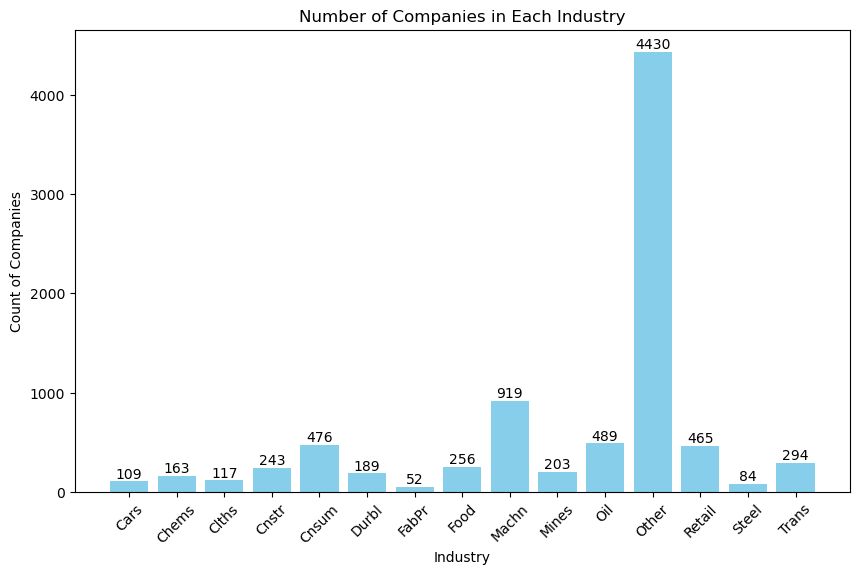

In [11]:
# Creating a bar chart to visualize the company distribution
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(count_ind.index, count_ind['gvkey'], color='skyblue')

# Add counts on top of bars
for i, v in enumerate(count_ind['gvkey']):
    plt.text(i, v, str(v), ha='center', va='bottom')

# Set title and axis labels
ax.set_title('Number of Companies in Each Industry')
ax.set_xlabel('Industry')
ax.set_ylabel('Count of Companies')

# Rotate x-axis labels 
plt.xticks(rotation=45)

plt.show()

In [12]:
# Counting the remaining number of companies 
data['gvkey'].nunique()

8489

In [13]:
# Determing the inventory valuation method by comparing the COGS with the inventory levels
mask_fifo = (df['cogs'] > df['cogs'].shift()) & (df['invt'] < df['invt'].shift())
mask_lifo = (df['cogs'] < df['cogs'].shift()) & (df['invt'] < df['invt'].shift())

df['Inventory Valuation Method'] = ''
df.loc[mask_fifo, 'Inventory Valuation Method'] = 'FIFO'
df.loc[mask_lifo, 'Inventory Valuation Method'] = 'LIFO'
df.loc[~(mask_fifo | mask_lifo), 'Inventory Valuation Method'] = 'Other'
df

gvkey   datadate  fyear indfmt consol popsrc datafmt     tic  \
0        1004 2003-05-31   2002   INDL      C      D     STD     AIR   
1        1010 2002-12-31   2002   INDL      C      D     STD   4165A   
2        1013 2002-10-31   2002   INDL      C      D     STD  ADCT.1   
3        1021 2002-06-30   2002   INDL      C      D     STD    IWKS   
4        1038 2003-03-31   2002   INDL      C      D     STD   AEN.2   
...       ...        ...    ...    ...    ...    ...     ...     ...   
54727  187462 2022-06-30   2022   INDL      C      D     STD      UI   
54728  187740 2022-09-30   2022   INDL      C      D     STD    MTSI   
54729  190455 2022-07-31   2022   INDL      C      D     STD    GWRE   
54730  193157 2022-09-30   2022   INDL      C      D     STD    INLB   
54731  324960 2022-06-30   2022   INDL      C      D     STD    FEAM   

                               conm acctstd  ...   itci  lifr      revt  \
0                          AAR CORP      DS  ...  0.000   0.0   606.337   
1                ACF INDUSTRIES INC      DS  ...  0.000   0.0   313.300   
2        ADC TELECOMMUNICATIONS INC      DS  ...  0.000   0.0  1047.700   
3                  AFP IMAGING CORP      DS  ...  0.000   0.0    20.087   
4        AMC ENTERTAINMENT INC -OLD      DS  ...  0.000   0.0  1791.570   
...                             ...     ...  ...    ...   ...       ...   
54727                  UBIQUITI INC      DS  ...  0.000   0.0  1691.692   
54728  MACOM TECHNLGY SOL HLDGS INC      DS  ...  8.995   0.0   675.170   
54729        GUIDEWIRE SOFTWARE INC      DS  ...  6.820   0.0   812.614   
54730              ITEM 9 LABS CORP      DS  ...  0.000   0.0    21.757   
54731     5E ADVANCED MATERIALS INC      DS  ...  0.000   0.0     0.000   

        txfed  costat  loc   sic  Fama French Industry    cpiret  \
0       0.293       A  USA  5080                 Machn  0.023769   
1      -3.300       I  USA  3743                 Trans  0.023769   
2     -67.000       I  USA  3661                 Other  0.023769   
3       0.000       I  USA  3844                 Other  0.023769   
4       6.995       I  USA  7830                 Other  0.023769   
...       ...     ...  ...   ...                   ...       ...   
54727  55.259       A  USA  3663                 Other  0.064545   
54728   0.072       A  USA  3674                 Machn  0.064545   
54729   1.937       A  USA  7372                 Other  0.064545   
54730   0.013       A  USA  2834                 Cnsum  0.064545   
54731   0.000       A  USA  1400                 Mines  0.064545   

       Inventory Valuation Method  
0                           Other  
1                            LIFO  
2                           Other  
3                            LIFO  
4                            FIFO  
...                           ...  
54727                       Other  
54728                        LIFO  
54729                        FIFO  
54730                       Other  
54731                        LIFO  

[54732 rows x 33 columns]

In [14]:
# Calculating the ITC ratio as ITC value fro income statement / total assets
df['ITC_ratio'] = df['itci'] / df['at']

# Calculating mean common equity value
mean_ceq = df.loc[df['ceq'] != 0, 'ceq'].mean()
df.loc[df['ceq'] == 0, 'ceq'] = mean_ceq

# Calculating the financial leverage as the ratio between total debt and common equity
df['fin_lev'] = df['dt'] / df['ceq']

# Calculating the tax-asset ratio as the federal tax divided by the total assets
df['tax_asset_ratio'] = df['txfed'] / df['at']

df

gvkey   datadate  fyear indfmt consol popsrc datafmt     tic  \
0        1004 2003-05-31   2002   INDL      C      D     STD     AIR   
1        1010 2002-12-31   2002   INDL      C      D     STD   4165A   
2        1013 2002-10-31   2002   INDL      C      D     STD  ADCT.1   
3        1021 2002-06-30   2002   INDL      C      D     STD    IWKS   
4        1038 2003-03-31   2002   INDL      C      D     STD   AEN.2   
...       ...        ...    ...    ...    ...    ...     ...     ...   
54727  187462 2022-06-30   2022   INDL      C      D     STD      UI   
54728  187740 2022-09-30   2022   INDL      C      D     STD    MTSI   
54729  190455 2022-07-31   2022   INDL      C      D     STD    GWRE   
54730  193157 2022-09-30   2022   INDL      C      D     STD    INLB   
54731  324960 2022-06-30   2022   INDL      C      D     STD    FEAM   

                               conm acctstd  ...   txfed  costat  loc   sic  \
0                          AAR CORP      DS  ...   0.293       A  USA  5080   
1                ACF INDUSTRIES INC      DS  ...  -3.300       I  USA  3743   
2        ADC TELECOMMUNICATIONS INC      DS  ... -67.000       I  USA  3661   
3                  AFP IMAGING CORP      DS  ...   0.000       I  USA  3844   
4        AMC ENTERTAINMENT INC -OLD      DS  ...   6.995       I  USA  7830   
...                             ...     ...  ...     ...     ...  ...   ...   
54727                  UBIQUITI INC      DS  ...  55.259       A  USA  3663   
54728  MACOM TECHNLGY SOL HLDGS INC      DS  ...   0.072       A  USA  3674   
54729        GUIDEWIRE SOFTWARE INC      DS  ...   1.937       A  USA  7372   
54730              ITEM 9 LABS CORP      DS  ...   0.013       A  USA  2834   
54731     5E ADVANCED MATERIALS INC      DS  ...   0.000       A  USA  1400   

       Fama French Industry    cpiret  Inventory Valuation Method  ITC_ratio  \
0                     Machn  0.023769                       Other   0.000000   
1                     Trans  0.023769                        LIFO   0.000000   
2                     Other  0.023769                       Other   0.000000   
3                     Other  0.023769                        LIFO   0.000000   
4                     Other  0.023769                        FIFO   0.000000   
...                     ...       ...                         ...        ...   
54727                 Other  0.064545                       Other   0.000000   
54728                 Machn  0.064545                        LIFO   0.005723   
54729                 Other  0.064545                        FIFO   0.003009   
54730                 Cnsum  0.064545                       Other   0.000000   
54731                 Mines  0.064545                        LIFO   0.000000   

        fin_lev  tax_asset_ratio  
0      0.789571         0.000427  
1      2.205579        -0.000891  
2      0.014750        -0.058556  
3      1.018066         0.000000  
4      2.494753         0.004689  
...         ...              ...  
54727 -2.228544         0.065418  
54728  0.752411         0.000046  
54729  0.327610         0.000854  
54730  0.388890         0.000117  
54731  0.008953         0.000000  

[54732 rows x 36 columns]

In [15]:
# Creating another dataframe
df1 = df.filter(['sic', 'Fama French Industry', 'gvkey', 'datadate', 'fyear', 'cogs',
                  'Inventory Valuation Method', 'ITC_ratio', 'fin_lev', 'capx', 
                 'tax_asset_ratio', 'cpiret', 'at', 'lifr'], axis=1)
df1

sic Fama French Industry   gvkey   datadate  fyear      cogs  \
0      5080                Machn    1004 2003-05-31   2002   496.747   
1      3743                Trans    1010 2002-12-31   2002   113.200   
2      3661                Other    1013 2002-10-31   2002   677.600   
3      3844                Other    1021 2002-06-30   2002    12.919   
4      7830                Other    1038 2003-03-31   2002  1514.986   
...     ...                  ...     ...        ...    ...       ...   
54727  3663                Other  187462 2022-06-30   2022  1009.780   
54728  3674                Machn  187740 2022-09-30   2022   237.352   
54729  7372                Other  190455 2022-07-31   2022   426.854   
54730  2834                Cnsum  193157 2022-09-30   2022    14.282   
54731  1400                Mines  324960 2022-06-30   2022     0.000   

      Inventory Valuation Method  ITC_ratio   fin_lev     capx  \
0                          Other   0.000000  0.789571    9.930   
1                           LIFO   0.000000  2.205579  111.000   
2                          Other   0.000000  0.014750   25.600   
3                           LIFO   0.000000  1.018066    0.034   
4                           FIFO   0.000000  2.494753  146.570   
...                          ...        ...       ...      ...   
54727                      Other   0.000000 -2.228544   13.468   
54728                       LIFO   0.005723  0.752411   26.513   
54729                       FIFO   0.003009  0.327610   21.776   
54730                      Other   0.000000  0.388890    4.327   
54731                       LIFO   0.000000  0.008953   11.400   

       tax_asset_ratio    cpiret        at  lifr  
0             0.000427  0.023769   686.621   0.0  
1            -0.000891  0.023769  3702.500   0.0  
2            -0.058556  0.023769  1144.200   0.0  
3             0.000000  0.023769     7.850   0.0  
4             0.004689  0.023769  1491.698   0.0  
...                ...       ...       ...   ...  
54727         0.065418  0.064545   844.712   0.0  
54728         0.000046  0.064545  1571.817   0.0  
54729         0.000854  0.064545  2266.897   0.0  
54730         0.000117  0.064545   110.762   0.0  
54731         0.000000  0.064545    70.886   0.0  

[54732 rows x 14 columns]

In [16]:
# Counting how many comapnies use and don't use the tax-relief provisions
count_invval = df1.groupby('gvkey')['Inventory Valuation Method'].nunique().value_counts()
count_itc = df1.groupby('gvkey')['ITC_ratio'].max().apply(lambda x: x != 0).value_counts()
count_lev = df1.groupby('gvkey')['fin_lev'].max().apply(lambda x: x != 0).value_counts()

# Creating a table
table = [["Inventory Valuation Method Used (LIFO)", count_invval[2], count_invval[[1, 3]]],
         ["ITC Used", count_itc[True], count_itc[False]],
         ["Financial leverage Used", count_lev[True], count_lev[False]]]

headers = ["Tax Provision", "Used", "Not Used"]

print(tabulate(table, headers=headers))


Tax Provision                             Used  Not Used
--------------------------------------  ------  ----------------------------------------------
Inventory Valuation Method Used (LIFO)    2827  1    5098
                                                3     564
                                                Name: Inventory Valuation Method, dtype: int64
ITC Used                                  2462  6027
Financial leverage Used                   6716  1773


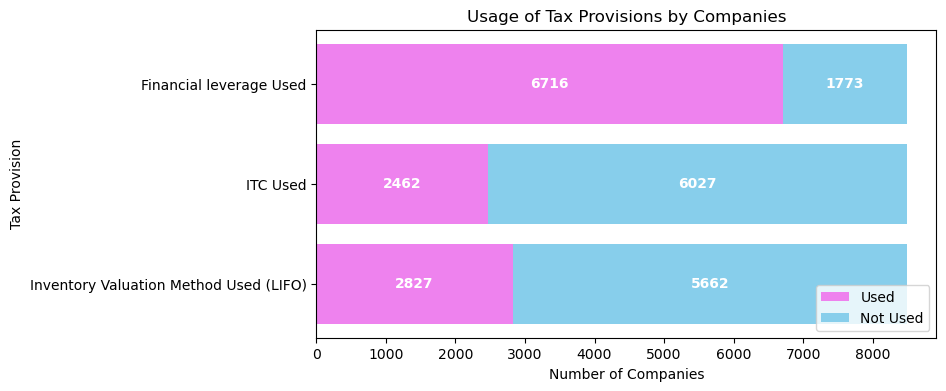

In [17]:
# Graphically visualizing the table
used = [count_invval[2], count_itc[True], count_lev[True]]
not_used = [count_invval[1]+count_invval[3], count_itc[False], count_lev[False]]
tax_provision = ['Inventory Valuation Method Used (LIFO)', 'ITC Used', 'Financial leverage Used']


# Creating the horizontal stacked bar chart
fig, ax = plt.subplots(figsize=(8,4))
ax.barh(tax_provision, used, label='Used', color='violet')
ax.barh(tax_provision, not_used, left=used, label='Not Used', color='skyblue')
# Adding level numbers to the bars
for i, v in enumerate(used):
    ax.text(v / 2, i, str(v), color='white', fontweight='bold', ha='center', va='center')
    ax.text(v + not_used[i] / 2, i, str(not_used[i]), color='white', fontweight='bold', ha='center', va='center')
ax.set_xlabel('Number of Companies')
ax.set_ylabel('Tax Provision')
ax.set_title('Usage of Tax Provisions by Companies')
ax.legend(loc='lower right')
plt.show()

In [18]:
# Dropping duplicates
df2 = df1.drop_duplicates(subset='gvkey', keep='first')
# Dropping firms that use inventory valuation methods other than LIFO and FIFO 
df2 = df1[(df1['Inventory Valuation Method'] == 'LIFO') | (df1['Inventory Valuation Method'] == 'FIFO')]
df2

sic Fama French Industry   gvkey   datadate  fyear      cogs  \
1      3743                Trans    1010 2002-12-31   2002   113.200   
3      3844                Other    1021 2002-06-30   2002    12.919   
4      7830                Other    1038 2003-03-31   2002  1514.986   
7      8700                Other    1082 2003-04-30   2002    63.993   
8      7370                Other    1084 2002-12-31   2002     0.078   
...     ...                  ...     ...        ...    ...       ...   
54721  1040                Mines  186109 2022-06-30   2022     0.000   
54725  2834                Cnsum  187166 2022-08-31   2022     0.000   
54728  3674                Machn  187740 2022-09-30   2022   237.352   
54729  7372                Other  190455 2022-07-31   2022   426.854   
54731  1400                Mines  324960 2022-06-30   2022     0.000   

      Inventory Valuation Method  ITC_ratio   fin_lev     capx  \
1                           LIFO   0.000000  2.205579  111.000   
3                           LIFO   0.000000  1.018066    0.034   
4                           FIFO   0.000000  2.494753  146.570   
7                           LIFO   0.000000  1.700724    0.374   
8                           LIFO   0.000000  0.000000    0.000   
...                          ...        ...       ...      ...   
54721                       LIFO   0.000000  1.449450    0.044   
54725                       LIFO   0.000000  0.000000    0.002   
54728                       LIFO   0.005723  0.752411   26.513   
54729                       FIFO   0.003009  0.327610   21.776   
54731                       LIFO   0.000000  0.008953   11.400   

       tax_asset_ratio    cpiret        at  lifr  
1            -0.000891  0.023769  3702.500   0.0  
3             0.000000  0.023769     7.850   0.0  
4             0.004689  0.023769  1491.698   0.0  
7            -0.002331  0.023769    73.797   0.0  
8             0.000000  0.023769     0.013   0.0  
...                ...       ...       ...   ...  
54721        -0.006998  0.064545    37.294   0.0  
54725         0.000000  0.064545     0.811   0.0  
54728         0.000046  0.064545  1571.817   0.0  
54729         0.000854  0.064545  2266.897   0.0  
54731         0.000000  0.064545    70.886   0.0  

[23260 rows x 14 columns]

## Cell Creation

### Single

In [19]:
LIFO = df2[df2['Inventory Valuation Method'] == 'LIFO']
FIFO = df2[df2['Inventory Valuation Method'] == 'FIFO']

high_itc = df2['ITC_ratio'].quantile(0.8)
low_itc = df2['ITC_ratio'].quantile(0.2)

HIGH_ITC = df2[df2['ITC_ratio'] >= high_itc]
HIGH_ITC = HIGH_ITC.sort_values(by='ITC_ratio', ascending=False)

LOW_ITC = df2[df2['ITC_ratio'] <= low_itc]
LOW_ITC = LOW_ITC.sort_values(by='ITC_ratio', ascending=False)

high_lev = df2['fin_lev'].quantile(0.8)
low_lev = df2['fin_lev'].quantile(0.2)

HIGH_FIN_LEV = df2[df2['fin_lev'] >= high_lev]
HIGH_FIN_LEV = HIGH_FIN_LEV.sort_values(by='fin_lev', ascending=False)

LOW_FIN_LEV = df2[df2['fin_lev'] <= low_lev]
LOW_FIN_LEV = LOW_FIN_LEV.sort_values(by='fin_lev', ascending=False)

### Pairs

In [20]:
LIFO_HIGH_FIN = LIFO.merge(HIGH_FIN_LEV)

FIFO_LOW_FIN = FIFO.merge(LOW_FIN_LEV)

LIFO_HIGH_ITC = LIFO.merge(HIGH_ITC)

FIFO_LOW_ITC = FIFO.merge(LOW_ITC)

HIGH_HIGH_ITC = HIGH_FIN_LEV.merge(HIGH_ITC)

LOW_LOW_ITC = LOW_FIN_LEV.merge(LOW_ITC)

### Triple

In [21]:
LIFO_HIGH_HIGH = pd.merge(pd.merge(LIFO, HIGH_FIN_LEV), HIGH_ITC)

FIFO_LOW_LOW = pd.merge(pd.merge(FIFO, LOW_FIN_LEV), LOW_ITC)

## Table 2

### Step 1

#### 1

In [22]:
LIFO_mean = LIFO.groupby('fyear')['capx'].mean()
FIFO_mean = FIFO.groupby('fyear')['capx'].mean()

LF_DMC = pd.DataFrame()
LF_DMC['LIFO vs FIFO'] = FIFO_mean - LIFO_mean



# Calculate the variances of the capx for LIFO and FIFO methods
var_capx_LIFO = LIFO.groupby('fyear')['capx'].var()
var_capx_FIFO = FIFO.groupby('fyear')['capx'].var()

# Calculate the sample size of LIFO and FIFO methods
n_LIFO = LIFO.groupby('fyear')['capx'].count()
n_FIFO = FIFO.groupby('fyear')['capx'].count()

# Calculate the standard error of the difference of means
std_err = np.sqrt(var_capx_LIFO/n_LIFO + var_capx_FIFO/n_FIFO)

# Calculate the t-statistic
t_stat_lf = pd.DataFrame()
t_stat_lf['t_stat_lf'] = LF_DMC['LIFO vs FIFO'] / std_err

t_stat_lf = t_stat_lf.applymap(lambda x: f"({x:.4f})")

#### 2

In [23]:
LFL_mean = LOW_FIN_LEV.groupby('fyear')['capx'].mean()
HFL_mean = HIGH_FIN_LEV.groupby('fyear')['capx'].mean()

HLF_DMC = pd.DataFrame()
HLF_DMC['HIGH_FIN_LEV vs LOW_FIN_LEV'] = HFL_mean - LFL_mean

var_capx_LFL = LOW_FIN_LEV.groupby('fyear')['capx'].var()
var_capx_HFL = HIGH_FIN_LEV.groupby('fyear')['capx'].var()

n_LFL = LOW_FIN_LEV.groupby('fyear')['capx'].count()
n_HFL = HIGH_FIN_LEV.groupby('fyear')['capx'].count()

std_err_FL = np.sqrt(var_capx_LFL/n_LFL + var_capx_HFL/n_HFL)

# Calculate the t-statistic
t_stat_FL = pd.DataFrame()
t_stat_FL['t_stat_FL'] = HLF_DMC['HIGH_FIN_LEV vs LOW_FIN_LEV'] / std_err_FL
t_stat_FL = t_stat_FL.applymap(lambda x: f"({x:.4f})")


#### 3

In [24]:
LITC_mean = LOW_ITC.groupby('fyear')['capx'].mean()
HITC_mean = HIGH_ITC.groupby('fyear')['capx'].mean()

HLITC_DMC = pd.DataFrame()
HLITC_DMC['HIGH_ITC vs LOW_ITC'] = HITC_mean - LITC_mean


var_capx_LITC = LOW_ITC.groupby('fyear')['capx'].var()
var_capx_HITC = HIGH_ITC.groupby('fyear')['capx'].var()

n_LITC = LOW_ITC.groupby('fyear')['capx'].count()
n_HITC = HIGH_ITC.groupby('fyear')['capx'].count()

std_err_ITC = np.sqrt(var_capx_LITC/n_LITC + var_capx_HITC/n_HITC)

# Calculate the t-statistic
t_stat_ITC = pd.DataFrame()
t_stat_ITC['t_stat_ITC'] = HLITC_DMC['HIGH_ITC vs LOW_ITC'] / std_err_ITC
t_stat_ITC = t_stat_ITC.applymap(lambda x: f"({x:.4f})")

### Step 2

#### Pair 1

In [25]:
LifoHF_mean = LIFO_HIGH_FIN.groupby('fyear')['capx'].mean()
FifoLF_mean = FIFO_LOW_FIN.groupby('fyear')['capx'].mean()

pair1_DMC = pd.DataFrame()
pair1_DMC['LIFO_HIGH_FIN vs FIFO_LOW_FIN'] = LifoHF_mean - FifoLF_mean


var_capx_LifoHF = LIFO_HIGH_FIN.groupby('fyear')['capx'].var()
var_capx_FifoLF = FIFO_LOW_FIN.groupby('fyear')['capx'].var()

n_LIFO_HIGH_FIN = LIFO_HIGH_FIN.groupby('fyear')['capx'].count()
n_FIFO_LOW_FIN = FIFO_LOW_FIN.groupby('fyear')['capx'].count()

std_err_pair1 = np.sqrt(var_capx_LifoHF/n_LIFO_HIGH_FIN + var_capx_FifoLF/n_FIFO_LOW_FIN)

# Calculate the t-statistic
t_stat_pair1 = pd.DataFrame()
t_stat_pair1['t_stat_pair1'] = pair1_DMC['LIFO_HIGH_FIN vs FIFO_LOW_FIN'] / std_err_pair1
t_stat_pair1 = t_stat_pair1.applymap(lambda x: f"({x:.4f})")

#### Pair 2

In [26]:
LifoHI_mean = LIFO_HIGH_ITC.groupby('fyear')['capx'].mean()
FifoLI_mean = FIFO_LOW_ITC.groupby('fyear')['capx'].mean()

pair2_DMC = pd.DataFrame()
pair2_DMC['LIFO_HIGH_ITC vs FIFO_LOW_ITC'] = LifoHI_mean - FifoLI_mean


var_capx_LifoHI = LIFO_HIGH_ITC.groupby('fyear')['capx'].var()
var_capx_FifoLI = FIFO_LOW_ITC.groupby('fyear')['capx'].var()

n_LIFO_HIGH_ITC = LIFO_HIGH_ITC.groupby('fyear')['capx'].count()
n_FIFO_LOW_ITC = FIFO_LOW_ITC.groupby('fyear')['capx'].count()

std_err_pair2 = np.sqrt(var_capx_LifoHI/n_LIFO_HIGH_ITC + var_capx_FifoLI/n_FIFO_LOW_ITC)

# Calculate the t-statistic
t_stat_pair2 = pd.DataFrame()
t_stat_pair2['t_stat_pair2'] = pair2_DMC['LIFO_HIGH_ITC vs FIFO_LOW_ITC'] / std_err_pair2
t_stat_pair2 = t_stat_pair2.applymap(lambda x: f"({x:.4f})")

#### Pair 3

In [27]:
HFHI_mean = HIGH_HIGH_ITC.groupby('fyear')['capx'].mean()
LFLI_mean = LOW_LOW_ITC.groupby('fyear')['capx'].mean()

pair3_DMC = pd.DataFrame()
pair3_DMC['HIGH_FIN_LEV_HIGH_ITC vs LOW_FIN_LEV_LOW_ITC'] = HFHI_mean - LFLI_mean


var_capx_HFHI = HIGH_HIGH_ITC.groupby('fyear')['capx'].var()
var_capx_LFLI = LOW_LOW_ITC.groupby('fyear')['capx'].var()

n_HF_HIGH_ITC = HIGH_HIGH_ITC.groupby('fyear')['capx'].count()
n_LF_LOW_ITC = LOW_LOW_ITC.groupby('fyear')['capx'].count()

std_err_pair3 = np.sqrt(var_capx_HFHI/n_HF_HIGH_ITC + var_capx_LFLI/n_LF_LOW_ITC)

# Calculate the t-statistic
t_stat_pair3 = pd.DataFrame()
t_stat_pair3['t_stat_pair3'] = pair3_DMC['HIGH_FIN_LEV_HIGH_ITC vs LOW_FIN_LEV_LOW_ITC'] / std_err_pair3
t_stat_pair3 = t_stat_pair3.applymap(lambda x: f"({x:.4f})")

#### Step 3

In [28]:
LHH_mean = LIFO_HIGH_HIGH.groupby('fyear')['capx'].mean()
FLL_mean = FIFO_LOW_LOW.groupby('fyear')['capx'].mean()

triple_DMC = pd.DataFrame()
triple_DMC['LIFO_HIGH_LEV_HIGH_ITC vs FIFO_LOW_LEV_LOW_ITC'] = LHH_mean - FLL_mean


var_capx_LHH = LIFO_HIGH_HIGH.groupby('fyear')['capx'].var()
var_capx_FLL = FIFO_LOW_LOW.groupby('fyear')['capx'].var()

n_LHH = LIFO_HIGH_HIGH.groupby('fyear')['capx'].count()
n_FLL = FIFO_LOW_LOW.groupby('fyear')['capx'].count()

std_err_triple = np.sqrt(var_capx_LHH/n_LHH + var_capx_FLL/n_FLL)

# Calculate the t-statistic
t_stat_triple = pd.DataFrame()
t_stat_triple['t_stat_triple'] = triple_DMC['LIFO_HIGH_LEV_HIGH_ITC vs FIFO_LOW_LEV_LOW_ITC'] / std_err_triple
t_stat_triple = t_stat_triple.applymap(lambda x: f"({x:.4f})")


### Formatting

In [29]:
#combining all dfs for diff in means into one
merged_df_dmc = pd.concat([LF_DMC, HLF_DMC, HLITC_DMC, pair1_DMC, pair2_DMC, pair3_DMC, triple_DMC], axis=1)
merged_df_dmc

LIFO vs FIFO  HIGH_FIN_LEV vs LOW_FIN_LEV  HIGH_ITC vs LOW_ITC  \
fyear                                                                   
2002      58.582302                    38.458900            22.664691   
2003      81.722793                    41.664490            24.888303   
2004      98.798047                    60.773496            26.081023   
2005     107.114404                    53.876754             4.860683   
2006     146.436879                    80.372400            12.805545   
2007     144.748278                   126.393178           -30.722923   
2008     156.880805                   142.000575           -26.478999   
2009     126.382933                   109.754410           -24.702900   
2010     142.297045                   145.427928           -36.309544   
2011     174.960740                   191.595243           -10.960439   
2012     103.570074                   181.593787           -26.954888   
2013     114.837890                   194.563014             7.777405   
2014     175.195433                   241.502448           -37.263270   
2015     180.846611                   164.057816           -22.876528   
2016     131.692277                   170.850420            -0.136350   
2017     173.689119                   132.478656             5.459546   
2018     191.757929                   187.090834           -33.857528   
2019     192.045168                   170.982535             6.767069   
2020     103.856298                   132.236231            24.553388   
2021      44.577142                    89.095178            30.129217   
2022     414.242165                   229.682320           156.197764   

       LIFO_HIGH_FIN vs FIFO_LOW_FIN  LIFO_HIGH_ITC vs FIFO_LOW_ITC  \
fyear                                                                 
2002                       -4.792602                     -46.986702   
2003                       10.704223                     -69.896936   
2004                       18.838220                     -81.073659   
2005                        5.084876                     -95.150520   
2006                       11.679374                    -145.594683   
2007                       40.294257                    -171.501036   
2008                        0.084690                    -181.774349   
2009                        6.637623                    -150.288357   
2010                       27.782112                    -168.409293   
2011                       73.133186                    -166.830254   
2012                      123.100651                    -109.870832   
2013                      133.938214                    -100.944214   
2014                      102.216188                    -201.334195   
2015                       31.345045                    -204.657400   
2016                       91.159715                    -133.482507   
2017                       92.284268                    -183.412021   
2018                      140.260855                    -248.430790   
2019                      135.200185                    -192.399965   
2020                      110.030206                     -87.229680   
2021                       97.851116                     -10.774616   
2022                       52.724857                    -276.130190   

       HIGH_FIN_LEV_HIGH_ITC vs LOW_FIN_LEV_LOW_ITC  \
fyear                                                 
2002                                      11.821805   
2003                                      16.226800   
2004                                      58.031840   
2005                                     132.054379   
2006                                     170.283037   
2007                                      87.155586   
2008                                      74.089062   
2009                                      82.382626   
2010                                      65.156923   
2011                                     125.222611   
2012                             

In [30]:
# Combining all the t-stat dataframes
merged_df_tstat = pd.concat([t_stat_lf, t_stat_FL, t_stat_ITC, t_stat_pair1, t_stat_pair2, 
                             t_stat_pair3, t_stat_triple], axis=1)
merged_df_tstat

t_stat_lf t_stat_FL t_stat_ITC t_stat_pair1 t_stat_pair2 t_stat_pair3  \
fyear                                                                         
2002   (3.3771)  (3.0252)   (0.7853)    (-0.3249)    (-3.0562)     (1.6117)   
2003   (3.6351)  (5.8545)   (0.8783)     (1.0517)    (-3.2552)     (2.2219)   
2004   (3.8735)  (5.4669)   (0.9066)     (1.5688)    (-2.9748)     (1.2413)   
2005   (3.9125)  (4.7589)   (0.3001)     (0.3771)    (-3.4832)     (1.4767)   
2006   (4.3469)  (5.9639)   (0.4445)     (0.4478)    (-4.2363)     (1.4970)   
2007   (4.2278)  (5.6074)  (-1.5825)     (0.8817)    (-4.5262)     (1.3141)   
2008   (4.6236)  (4.9868)  (-1.5097)     (0.0021)    (-4.7290)     (1.4759)   
2009   (3.8922)  (4.4233)  (-2.1539)     (0.2616)    (-3.7316)     (1.8260)   
2010   (4.0881)  (4.4843)  (-2.9180)     (0.6425)    (-4.0802)     (1.6427)   
2011   (4.2039)  (4.6966)  (-0.5325)     (1.7850)    (-3.4106)     (1.9281)   
2012   (2.9220)  (4.7858)  (-2.0490)     (2.7982)    (-2.9196)     (1.7369)   
2013   (3.2656)  (5.2864)   (0.3515)     (2.9911)    (-3.1185)     (3.5893)   
2014   (4.1043)  (5.8405)  (-1.8448)     (1.8440)    (-4.1007)     (2.1450)   
2015   (4.5362)  (5.1130)  (-1.2131)     (0.9346)    (-4.0826)     (2.3854)   
2016   (3.1490)  (5.0433)  (-0.0059)     (3.5164)    (-2.6081)     (2.2084)   
2017   (3.3467)  (5.0897)   (0.2115)     (2.6781)    (-2.6061)     (3.4182)   
2018   (3.6326)  (4.9291)  (-1.2696)     (3.0499)    (-3.4366)     (2.3049)   
2019   (3.7635)  (4.7632)   (0.2221)     (3.0365)    (-3.2142)     (2.1969)   
2020   (2.7215)  (4.4656)   (0.8733)     (2.7757)    (-1.8955)     (2.2288)   
2021   (1.6883)  (2.9000)   (1.0999)     (2.7048)    (-0.3419)     (2.7519)   
2022   (1.9798)  (2.0000)   (1.4728)     (1.8706)    (-0.9766)     (1.6191)   

      t_stat_triple  
fyear                
2002      (-0.4588)  
2003       (0.5530)  
2004      (-0.6288)  
2005      (-1.1740)  
2006      (-1.2006)  
2007      (-1.3875)  
2008      (-0.8075)  
2009       (0.1529)  
2010       (0.1893)  
2011       (0.9433)  
2012       (0.6474)  
2013       (2.3852)  
2014      (-0.2660)  
2015      (-0.0648)  
2016       (3.1217)  
2017       (1.9628)  
2018       (1.2323)  
2019       (1.4232)  
2020       (1.3323)  
2021       (1.3013)  
2022          (nan)

In [31]:
pd.set_option('display.max_columns', None)
# Creating the table
table2 = pd.DataFrame(pd.concat([merged_df_dmc['LIFO vs FIFO'], merged_df_tstat['t_stat_lf'], 
                                 merged_df_dmc['HIGH_FIN_LEV vs LOW_FIN_LEV'], merged_df_tstat['t_stat_FL'], 
                                 merged_df_dmc['HIGH_ITC vs LOW_ITC'], merged_df_tstat['t_stat_ITC'], 
                                merged_df_dmc['LIFO_HIGH_FIN vs FIFO_LOW_FIN'], merged_df_tstat['t_stat_pair1'], 
                                merged_df_dmc['LIFO_HIGH_ITC vs FIFO_LOW_ITC'], merged_df_tstat['t_stat_pair2'], 
                                merged_df_dmc['HIGH_FIN_LEV_HIGH_ITC vs LOW_FIN_LEV_LOW_ITC'], merged_df_tstat['t_stat_pair3'],
                                merged_df_dmc['LIFO_HIGH_LEV_HIGH_ITC vs FIFO_LOW_LEV_LOW_ITC'], 
                                merged_df_tstat['t_stat_triple']], axis=1))
table2 = table2.transpose()
table2

fyear                                                2002       2003  \
LIFO vs FIFO                                    58.582302  81.722793   
t_stat_lf                                        (3.3771)   (3.6351)   
HIGH_FIN_LEV vs LOW_FIN_LEV                       38.4589   41.66449   
t_stat_FL                                        (3.0252)   (5.8545)   
HIGH_ITC vs LOW_ITC                             22.664691  24.888303   
t_stat_ITC                                       (0.7853)   (0.8783)   
LIFO_HIGH_FIN vs FIFO_LOW_FIN                   -4.792602  10.704223   
t_stat_pair1                                    (-0.3249)   (1.0517)   
LIFO_HIGH_ITC vs FIFO_LOW_ITC                  -46.986702 -69.896936   
t_stat_pair2                                    (-3.0562)  (-3.2552)   
HIGH_FIN_LEV_HIGH_ITC vs LOW_FIN_LEV_LOW_ITC    11.821805    16.2268   
t_stat_pair3                                     (1.6117)   (2.2219)   
LIFO_HIGH_LEV_HIGH_ITC vs FIFO_LOW_LEV_LOW_ITC  -7.740705   9.132605   
t_stat_triple                                   (-0.4588)   (0.5530)   

fyear                                                2004        2005  \
LIFO vs FIFO                                    98.798047  107.114404   
t_stat_lf                                        (3.8735)    (3.9125)   
HIGH_FIN_LEV vs LOW_FIN_LEV                     60.773496   53.876754   
t_stat_FL                                        (5.4669)    (4.7589)   
HIGH_ITC vs LOW_ITC                             26.081023    4.860683   
t_stat_ITC                                       (0.9066)    (0.3001)   
LIFO_HIGH_FIN vs FIFO_LOW_FIN                    18.83822    5.084876   
t_stat_pair1                                     (1.5688)    (0.3771)   
LIFO_HIGH_ITC vs FIFO_LOW_ITC                  -81.073659   -95.15052   
t_stat_pair2                                    (-2.9748)   (-3.4832)   
HIGH_FIN_LEV_HIGH_ITC vs LOW_FIN_LEV_LOW_ITC     58.03184  132.054379   
t_stat_pair3                                     (1.2413)    (1.4767)   
LIFO_HIGH_LEV_HIGH_ITC vs FIFO_LOW_LEV_LOW_ITC  -6.342877  -20.768723   
t_stat_triple                                   (-0.6288)   (-1.1740)   

fyear                                                 2006        2007  \
LIFO vs FIFO                                    146.436879  144.748278   
t_stat_lf                                         (4.3469)    (4.2278)   
HIGH_FIN_LEV vs LOW_FIN_LEV                        80.3724  126.393178   
t_stat_FL                                         (5.9639)    (5.6074)   
HIGH_ITC vs LOW_ITC                              12.805545  -30.722923   
t_stat_ITC                                        (0.4445)   (-1.5825)   
LIFO_HIGH_FIN vs FIFO_LOW_FIN                    11.679374   40.294257   
t_stat_pair1                                      (0.4478)    (0.8817)   
LIFO_HIGH_ITC vs FIFO_LOW_ITC                  -145.594683 -171.501036   
t_stat_pair2                                     (-4.2363)   (-4.5262)   
HIGH_FIN_LEV_HIGH_ITC vs LOW_FIN_LEV_LOW_ITC    170.283037   87.155586   
t_stat_pair3                                      (1.4970)    (1.3141)   
LIFO_HIGH_LEV_HIGH_ITC vs FIFO_LOW_LEV_LOW_ITC  -16.818466  -32.614822   
t_stat_triple                                    (-1.2006)   (-1.3875)   

fyear                                                 2008        2009  \
LIFO vs FIFO                                    156.880805  126.382933   
t_stat_lf                                         (4.6236)    (3.8922)   
HIGH_FIN_LEV vs LOW_FIN_LEV                     142.000575   109.75441   
t_stat_FL                                         (4.9868)    (4.4233)   
HIGH_ITC vs LOW_ITC                             -26.478999    -24.7029   
t_stat_ITC                                       (-1.5097)   (-2.1539)   
LIFO_HIGH_FIN vs FIFO_LOW_FIN                      0.08469    6.637623   
t_stat_pair1                                      (0.0021)    (0.2616)   
LIFO_HIGH_ITC vs FIFO_LOW_ITC                 

## Table 3

### Step 1

#### 1

In [32]:
LIFO_tax_mean = LIFO.groupby('fyear')['tax_asset_ratio'].mean()
FIFO_tax_mean = FIFO.groupby('fyear')['tax_asset_ratio'].mean()

LF_DMT = pd.DataFrame()
LF_DMT['LIFO vs FIFO'] = LIFO_tax_mean - FIFO_tax_mean

var_tax_LIFO = LIFO.groupby('fyear')['tax_asset_ratio'].var()
var_tax_FIFO = FIFO.groupby('fyear')['tax_asset_ratio'].var()

n_LIFO_t = LIFO.groupby('fyear')['tax_asset_ratio'].count()
n_FIFO_t = FIFO.groupby('fyear')['tax_asset_ratio'].count()

std_err_t = np.sqrt(var_tax_LIFO/n_LIFO_t + var_tax_FIFO/n_FIFO_t)

t_stat_lft = pd.DataFrame()
t_stat_lft['t_stat_lf_t'] = LF_DMT['LIFO vs FIFO'] / std_err_t
t_stat_lft = t_stat_lft.applymap(lambda x: f"({x:.4f})")

#### 2

In [33]:
LFL_tax_mean = LOW_FIN_LEV.groupby('fyear')['tax_asset_ratio'].mean()
HFL_tax_mean = HIGH_FIN_LEV.groupby('fyear')['tax_asset_ratio'].mean()

HFL_DMT = pd.DataFrame()
HFL_DMT['HIGH_FIN_LEV vs LOW_FIN_LEV'] = HFL_tax_mean - LFL_tax_mean

var_tax_LFL = LOW_FIN_LEV.groupby('fyear')['tax_asset_ratio'].var()
var_tax_HFL = HIGH_FIN_LEV.groupby('fyear')['tax_asset_ratio'].var()

n_LFL_t = LOW_FIN_LEV.groupby('fyear')['tax_asset_ratio'].count()
n_HFL_t = HIGH_FIN_LEV.groupby('fyear')['tax_asset_ratio'].count()

se_flt = np.sqrt(var_tax_HFL/n_HFL_t + var_tax_LFL/n_LFL_t)

t_stat_flt = pd.DataFrame()
t_stat_flt['t_stat_lf_t'] = HFL_DMT['HIGH_FIN_LEV vs LOW_FIN_LEV'] / se_flt
t_stat_flt = t_stat_flt.applymap(lambda x: f"({x:.4f})")

#### 3

In [34]:
LITC_tax_mean = LOW_ITC.groupby('fyear')['tax_asset_ratio'].mean()
HITC_tax_mean = HIGH_ITC.groupby('fyear')['tax_asset_ratio'].mean()

HLITC_DMT = pd.DataFrame()
HLITC_DMT['HIGH_ITC vs LOW_ITC'] = HITC_tax_mean - LITC_tax_mean

var_tax_LITC = LOW_ITC.groupby('fyear')['tax_asset_ratio'].var()
var_tax_HITC = HIGH_ITC.groupby('fyear')['tax_asset_ratio'].var()

n_LITC_t = LOW_ITC.groupby('fyear')['tax_asset_ratio'].count()
n_HITC_t = HIGH_ITC.groupby('fyear')['tax_asset_ratio'].count()

se_itct = np.sqrt(var_tax_HITC/n_HITC_t + var_tax_LITC/n_LITC_t)

t_stat_itct = pd.DataFrame()
t_stat_itct['t_stat_itc_t'] = HLITC_DMT['HIGH_ITC vs LOW_ITC'] / se_itct
t_stat_itct = t_stat_itct.applymap(lambda x: f"({x:.4f})")

### Step 2

#### Pair 1

In [35]:
LifoHF_tax_mean = LIFO_HIGH_FIN.groupby('fyear')['tax_asset_ratio'].mean()
FifoLF_tax_mean = FIFO_LOW_FIN.groupby('fyear')['tax_asset_ratio'].mean()

pair1_DMT = pd.DataFrame()
pair1_DMT['LIFO_HIGH_FIN vs FIFO_LOW_FIN'] = LifoHF_tax_mean - FifoLF_tax_mean

var_tax_LifoHF = LIFO_HIGH_FIN.groupby('fyear')['tax_asset_ratio'].var()
var_tax_FifoLF = FIFO_LOW_FIN.groupby('fyear')['tax_asset_ratio'].var()

n_LifoHF_t = LIFO_HIGH_FIN.groupby('fyear')['tax_asset_ratio'].count()
n_FifoLF_t = FIFO_LOW_FIN.groupby('fyear')['tax_asset_ratio'].count()

se_p1t = np.sqrt(var_tax_LifoHF/n_LifoHF_t + var_tax_FifoLF/n_FifoLF_t)


t_stat_p1t = pd.DataFrame()
t_stat_p1t['t_stat_p1_t'] = pair1_DMT['LIFO_HIGH_FIN vs FIFO_LOW_FIN'] / se_p1t
t_stat_p1t = t_stat_p1t.applymap(lambda x: f"({x:.4f})")

#### Pair 2

In [36]:
LifoHI_tax_mean = LIFO_HIGH_ITC.groupby('fyear')['tax_asset_ratio'].mean()
FifoLI_tax_mean = FIFO_LOW_ITC.groupby('fyear')['tax_asset_ratio'].mean()

pair2_DMT = pd.DataFrame()
pair2_DMT['LIFO_HIGH_ITC vs FIFO_LOW_ITC'] = LifoHI_tax_mean - FifoLI_tax_mean

var_tax_LifoHI = LIFO_HIGH_ITC.groupby('fyear')['tax_asset_ratio'].var()
var_tax_FifoLI = FIFO_LOW_ITC.groupby('fyear')['tax_asset_ratio'].var()

n_LifoHI_t = LIFO_HIGH_ITC.groupby('fyear')['tax_asset_ratio'].count()
n_FifoLI_t = FIFO_LOW_ITC.groupby('fyear')['tax_asset_ratio'].count()

se_p2t = np.sqrt(var_tax_LifoHI/n_LifoHI_t + var_tax_FifoLI/n_FifoLI_t)

t_stat_p2t = pd.DataFrame()
t_stat_p2t['t_stat_p2_t'] = pair2_DMT['LIFO_HIGH_ITC vs FIFO_LOW_ITC'] / se_p2t
t_stat_p2t = t_stat_p2t.applymap(lambda x: f"({x:.4f})")

#### Pair 3

In [37]:
HFHI_tax_mean = HIGH_HIGH_ITC.groupby('fyear')['tax_asset_ratio'].mean()
LFLI_tax_mean = LOW_LOW_ITC.groupby('fyear')['tax_asset_ratio'].mean()

pair3_DMT = pd.DataFrame()
pair3_DMT['HIGH_FIN_LEV_HIGH_ITC vs LOW_FIN_LEV_LOW_ITC'] = HFHI_tax_mean - LFLI_tax_mean

var_tax_HFHI = HIGH_HIGH_ITC.groupby('fyear')['tax_asset_ratio'].var()
var_tax_LFLI = LOW_LOW_ITC.groupby('fyear')['tax_asset_ratio'].var()

n_HFHI_t = HIGH_HIGH_ITC.groupby('fyear')['tax_asset_ratio'].count()
n_LFLI_t = LOW_LOW_ITC.groupby('fyear')['tax_asset_ratio'].count()

se_p3t = np.sqrt(var_tax_HFHI/n_HFHI_t + var_tax_LFLI/n_LFLI_t)

t_stat_p3t = pd.DataFrame()
t_stat_p3t['t_stat_p3_t'] = pair3_DMT['HIGH_FIN_LEV_HIGH_ITC vs LOW_FIN_LEV_LOW_ITC'] / se_p3t
t_stat_p3t = t_stat_p3t.applymap(lambda x: f"({x:.4f})")

### Step 3

In [38]:
LHH_tax_mean = LIFO_HIGH_HIGH.groupby('fyear')['tax_asset_ratio'].mean()
FLL_tax_mean = FIFO_LOW_LOW.groupby('fyear')['tax_asset_ratio'].mean()

triple_DMT = pd.DataFrame()
triple_DMT['LIFO_HIGH_LEV_HIGH_ITC vs FIFO_LOW_LEV_LOW_ITC'] = LHH_tax_mean - FLL_tax_mean

var_tax_LHH = LIFO_HIGH_HIGH.groupby('fyear')['tax_asset_ratio'].var()
var_tax_FLL = FIFO_LOW_LOW.groupby('fyear')['tax_asset_ratio'].var()

n_LHH_t = LIFO_HIGH_HIGH.groupby('fyear')['tax_asset_ratio'].count()
n_FLL_t = FIFO_LOW_LOW.groupby('fyear')['tax_asset_ratio'].count()

se_triple_t = np.sqrt(var_tax_LHH/n_LHH_t + var_tax_FLL/n_FLL_t)

t_stat_triple_t = pd.DataFrame()
t_stat_triple_t['t_stat_triple_t'] = triple_DMT['LIFO_HIGH_LEV_HIGH_ITC vs FIFO_LOW_LEV_LOW_ITC'] / se_triple_t
t_stat_triple_t = t_stat_triple_t.applymap(lambda x: f"({x:.4f})")


### Formatting

In [39]:
# Creating the table
table3 = pd.DataFrame(pd.concat([LF_DMT['LIFO vs FIFO'], t_stat_lft['t_stat_lf_t'], 
                                 HFL_DMT['HIGH_FIN_LEV vs LOW_FIN_LEV'], t_stat_flt['t_stat_lf_t'], 
                                 HLITC_DMT['HIGH_ITC vs LOW_ITC'], t_stat_itct['t_stat_itc_t'], 
                                pair1_DMT['LIFO_HIGH_FIN vs FIFO_LOW_FIN'], t_stat_p1t['t_stat_p1_t'], 
                                pair2_DMT['LIFO_HIGH_ITC vs FIFO_LOW_ITC'], t_stat_p2t['t_stat_p2_t'], 
                                pair3_DMT['HIGH_FIN_LEV_HIGH_ITC vs LOW_FIN_LEV_LOW_ITC'], t_stat_p3t['t_stat_p3_t'],
                                triple_DMT['LIFO_HIGH_LEV_HIGH_ITC vs FIFO_LOW_LEV_LOW_ITC'], 
                                t_stat_triple_t['t_stat_triple_t']], axis=1))
table3 = table3.transpose()
table3

fyear                                                2002       2003  \
LIFO vs FIFO                                    -0.004017  -0.004084   
t_stat_lf_t                                     (-2.2216)  (-1.2505)   
HIGH_FIN_LEV vs LOW_FIN_LEV                      0.001012   0.004174   
t_stat_lf_t                                      (0.4985)   (0.8051)   
HIGH_ITC vs LOW_ITC                              0.000162   0.005216   
t_stat_itc_t                                     (0.0743)   (1.7705)   
LIFO_HIGH_FIN vs FIFO_LOW_FIN                   -0.003474   0.000912   
t_stat_p1_t                                     (-1.0545)   (0.4601)   
LIFO_HIGH_ITC vs FIFO_LOW_ITC                   -0.002797   0.001802   
t_stat_p2_t                                     (-1.1331)   (0.9919)   
HIGH_FIN_LEV_HIGH_ITC vs LOW_FIN_LEV_LOW_ITC    -0.001351   0.011782   
t_stat_p3_t                                     (-0.1901)   (1.6602)   
LIFO_HIGH_LEV_HIGH_ITC vs FIFO_LOW_LEV_LOW_ITC  -0.006049   0.011474   
t_stat_triple_t                                 (-0.7090)   (1.6733)   

fyear                                                2004       2005  \
LIFO vs FIFO                                     -0.00257  -0.007166   
t_stat_lf_t                                     (-1.7174)  (-2.7846)   
HIGH_FIN_LEV vs LOW_FIN_LEV                     -0.000692    0.00074   
t_stat_lf_t                                     (-0.4283)   (0.1949)   
HIGH_ITC vs LOW_ITC                              0.003166     0.0045   
t_stat_itc_t                                     (1.3153)   (1.5380)   
LIFO_HIGH_FIN vs FIFO_LOW_FIN                   -0.001865  -0.005285   
t_stat_p1_t                                     (-0.7152)  (-1.9377)   
LIFO_HIGH_ITC vs FIFO_LOW_ITC                    0.001475  -0.000808   
t_stat_p2_t                                      (0.5017)  (-0.2483)   
HIGH_FIN_LEV_HIGH_ITC vs LOW_FIN_LEV_LOW_ITC    -0.000064   0.009742   
t_stat_p3_t                                     (-0.0210)   (1.2100)   
LIFO_HIGH_LEV_HIGH_ITC vs FIFO_LOW_LEV_LOW_ITC  -0.002711   0.009094   
t_stat_triple_t                                 (-0.7569)   (0.7100)   

fyear                                                2006       2007  \
LIFO vs FIFO                                    -0.006818  -0.005493   
t_stat_lf_t                                     (-3.1378)  (-2.7110)   
HIGH_FIN_LEV vs LOW_FIN_LEV                      -0.00386  -0.000343   
t_stat_lf_t                                     (-1.8545)  (-0.1710)   
HIGH_ITC vs LOW_ITC                              0.003568   0.002551   
t_stat_itc_t                                     (1.4224)   (1.0292)   
LIFO_HIGH_FIN vs FIFO_LOW_FIN                   -0.009755  -0.011235   
t_stat_p1_t                                     (-2.3598)  (-2.2127)   
LIFO_HIGH_ITC vs FIFO_LOW_ITC                   -0.002926  -0.002225   
t_stat_p2_t                                     (-0.8297)  (-0.6305)   
HIGH_FIN_LEV_HIGH_ITC vs LOW_FIN_LEV_LOW_ITC    -0.002551   0.007361   
t_stat_p3_t                                     (-0.5939)   (0.7545)   
LIFO_HIGH_LEV_HIGH_ITC vs FIFO_LOW_LEV_LOW_ITC  -0.012251  -0.003137   
t_stat_triple_t                                 (-2.5221)  (-0.2012)   

fyear                                                2008       2009  \
LIFO vs FIFO                                    -0.005843  -0.003238   
t_stat_lf_t                                     (-1.2158)  (-0.7231)   
HIGH_FIN_LEV vs LOW_FIN_LEV                      0.005592   -0.00731   
t_stat_lf_t                                      (0.7047)  (-1.0982)   
HIGH_ITC vs LOW_ITC                              0.003567  -0.001615   
t_stat_itc_t                                     (0.7733)  (-0.3819)   
LIFO_HIGH_FIN vs FIFO_LOW_FIN                   -0.005308  -0.010964   
t_stat_p1_t                                     (-1.2923)  (-2.1582)   
LIFO_HIGH_ITC vs FIFO_LOW_ITC                   -0.001892  -0.004615   
t_stat_p2_t                          

## Regressions

In [40]:
# Creating a LIFO dummy 
df1['LIFO_dummy'] = 0
df1.loc[df1['Inventory Valuation Method'] == 'LIFO', 'LIFO_dummy'] = 1
df1['FIFO_dummy'] = 0
df1.loc[df1['Inventory Valuation Method'] == 'FIFO', 'FIFO_dummy'] = 1
df1 = df1.rename(columns={'lifr': 'LIFR_ratio'})
# Calculating capex over total assets ratio 
df1['capx_at'] = df1['capx']/df1['at']
df1.replace([np.inf, -np.inf], np.nan, inplace=True)
df1 = df1.dropna()
# Setting indexes
df1 = df1.set_index(['gvkey', 'datadate'])
df1

sic Fama French Industry  fyear      cogs  \
gvkey  datadate                                                 
1004   2003-05-31  5080                Machn   2002   496.747   
1010   2002-12-31  3743                Trans   2002   113.200   
1013   2002-10-31  3661                Other   2002   677.600   
1021   2002-06-30  3844                Other   2002    12.919   
1038   2003-03-31  7830                Other   2002  1514.986   
...                 ...                  ...    ...       ...   
187462 2022-06-30  3663                Other   2022  1009.780   
187740 2022-09-30  3674                Machn   2022   237.352   
190455 2022-07-31  7372                Other   2022   426.854   
193157 2022-09-30  2834                Cnsum   2022    14.282   
324960 2022-06-30  1400                Mines   2022     0.000   

                  Inventory Valuation Method  ITC_ratio   fin_lev     capx  \
gvkey  datadate                                                              
1004   2003-05-31                      Other   0.000000  0.789571    9.930   
1010   2002-12-31                       LIFO   0.000000  2.205579  111.000   
1013   2002-10-31                      Other   0.000000  0.014750   25.600   
1021   2002-06-30                       LIFO   0.000000  1.018066    0.034   
1038   2003-03-31                       FIFO   0.000000  2.494753  146.570   
...                                      ...        ...       ...      ...   
187462 2022-06-30                      Other   0.000000 -2.228544   13.468   
187740 2022-09-30                       LIFO   0.005723  0.752411   26.513   
190455 2022-07-31                       FIFO   0.003009  0.327610   21.776   
193157 2022-09-30                      Other   0.000000  0.388890    4.327   
324960 2022-06-30                       LIFO   0.000000  0.008953   11.400   

                   tax_asset_ratio    cpiret        at  LIFR_ratio  \
gvkey  datadate                                                      
1004   2003-05-31         0.000427  0.023769   686.621         0.0   
1010   2002-12-31        -0.000891  0.023769  3702.500         0.0   
1013   2002-10-31        -0.058556  0.023769  1144.200         0.0   
1021   2002-06-30         0.000000  0.023769     7.850         0.0   
1038   2003-03-31         0.004689  0.023769  1491.698         0.0   
...                            ...       ...       ...         ...   
187462 2022-06-30         0.065418  0.064545   844.712         0.0   
187740 2022-09-30         0.000046  0.064545  1571.817         0.0   
190455 2022-07-31         0.000854  0.064545  2266.897         0.0   
193157 2022-09-30         0.000117  0.064545   110.762         0.0   
324960 2022-06-30         0.000000  0.064545    70.886         0.0   

                   LIFO_dummy  FIFO_dummy   capx_at  
gvkey  datadate                                      
1004   2003-05-31           0           0  0.014462  
1010   2002-12-31           1           0  0.029980  
1013   2002-10-31           0           0  0.022374  
1021   2002-06-30           1           0  0.004331  
1038   2003-03-31           0           1  0.098257  
...                       ...         ...       ...  
187462 2022-06-30           0           0  0.015944  
187740 2022-09-30           1           0  0.016868  
190455 2022-07-31           0           1  0.009606  
193157 2022-09-30           0           0  0.039066  
324960 2022-06-30           1           0  0.160822  

[54169 rows x 15 columns]

### 1

##### First regression we run is to test the effect of inflation on the capital expenditure ratio. 
H_0: There is no effect of inflation on capx ratio of a firm.
H_1: Inflation has an effect on the capx ratio of a firm. 
##### We first run the baseline regression, without any fixed effects. After which we include only firm fixed effects, so that we don't remove the effect of inflation with time. And finally, we run a regression with bot, firm and time fixed effects. 
We then compare the results in a table. 

In [41]:
## Running Panel OLS regression with baseline specification

x1 = sm.add_constant(df1['cpiret'])
mod1 = PanelOLS(df1.capx_at, x1)
base_reg1 = mod1.fit(cov_type='robust')
base_reg1.summary

<class 'linearmodels.compat.statsmodels.Summary'>
"""
                          PanelOLS Estimation Summary                           
================================================================================
Dep. Variable:                capx_at   R-squared:                       8.7e-06
Estimator:                   PanelOLS   R-squared (Between):           -8.35e-05
No. Observations:               54169   R-squared (Within):           -2.619e-06
Date:                Mon, Apr 03 2023   R-squared (Overall):             8.7e-06
Time:                        15:48:19   Log-likelihood                -1.007e+05
Cov. Estimator:                Robust                                           
                                        F-statistic:                      0.4713
Entities:                        8468   P-value                           0.4924
Avg Obs:                       6.3969   Distribution:                 F(1,54167)
Min Obs:                       1.0000                                           
Max Obs:                       21.000   F-statistic (robust):             7.2016
                                        P-value                           0.0073
Time periods:                     247   Distribution:                 F(1,54167)
Avg Obs:                       219.31                                           
Min Obs:                       6.0000                                           
Max Obs:                       2374.0                                           
                                                                                
                             Parameter Estimates                              
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const          0.0698     0.0076     9.1823     0.0000      0.0549      0.0847
cpiret        -0.3311     0.1234    -2.6836     0.0073     -0.5729     -0.0893
==============================================================================


"""

In [42]:
## Running Panel OLS regression with firm fixed effects

x1 = sm.add_constant(df1['cpiret'])
mod1 = PanelOLS(df1.capx_at, x1, entity_effects=True)
ffe_reg1 = mod1.fit(cov_type='robust')
ffe_reg1.summary

<class 'linearmodels.compat.statsmodels.Summary'>
"""
                          PanelOLS Estimation Summary                           
================================================================================
Dep. Variable:                capx_at   R-squared:                     1.685e-06
Estimator:                   PanelOLS   R-squared (Between):             -0.0001
No. Observations:               54169   R-squared (Within):            1.685e-06
Date:                Mon, Apr 03 2023   R-squared (Overall):           5.408e-06
Time:                        15:48:20   Log-likelihood                 -8.97e+04
Cov. Estimator:                Robust                                           
                                        F-statistic:                      0.0770
Entities:                        8468   P-value                           0.7814
Avg Obs:                       6.3969   Distribution:                 F(1,45700)
Min Obs:                       1.0000                                           
Max Obs:                       21.000   F-statistic (robust):             0.6481
                                        P-value                           0.4208
Time periods:                     247   Distribution:                 F(1,45700)
Avg Obs:                       219.31                                           
Min Obs:                       6.0000                                           
Max Obs:                       2374.0                                           
                                                                                
                             Parameter Estimates                              
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const          0.0650     0.0074     8.7571     0.0000      0.0504      0.0795
cpiret        -0.1274     0.1583    -0.8050     0.4208     -0.4377      0.1828
==============================================================================

F-test for Poolability: 2.7130
P-value: 0.0000
Distribution: F(8467,45700)

Included effects: Entity
"""

In [43]:
## Running Panel OLS regression with firm and time fixed effects 

x1 = sm.add_constant(df1['cpiret'])
mod1 = PanelOLS(df1.capx_at, x1, entity_effects=True, time_effects=True)
ftfe_reg1 = mod1.fit(cov_type='robust')
ftfe_reg1.summary

<class 'linearmodels.compat.statsmodels.Summary'>
"""
                          PanelOLS Estimation Summary                           
================================================================================
Dep. Variable:                capx_at   R-squared:                     3.331e-16
Estimator:                   PanelOLS   R-squared (Between):             -0.4455
No. Observations:               54169   R-squared (Within):              -1.1776
Date:                Mon, Apr 03 2023   R-squared (Overall):             -0.8974
Time:                        15:48:36   Log-likelihood                -8.957e+04
Cov. Estimator:                Robust                                           
                                        F-statistic:                   1.528e-11
Entities:                        8468   P-value                           1.0000
Avg Obs:                       6.3969   Distribution:                 F(1,45454)
Min Obs:                       1.0000                                           
Max Obs:                       21.000   F-statistic (robust):          1.431e-10
                                        P-value                           1.0000
Time periods:                     247   Distribution:                 F(1,45454)
Avg Obs:                       219.31                                           
Min Obs:                       6.0000                                           
Max Obs:                       2374.0                                           
                                                                                
                             Parameter Estimates                              
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const          2.5600  2.063e+05  1.241e-05     1.0000  -4.043e+05   4.043e+05
cpiret        -106.66  8.917e+06 -1.196e-05     1.0000  -1.748e+07   1.748e+07
==============================================================================

F-test for Poolability: 2.6593
P-value: 0.0000
Distribution: F(8713,45454)

Included effects: Entity, Time
"""

In [44]:
# Comparing estimation results together in an ordered dictionary
result = OrderedDict()
result["Baseline"] = base_reg1
result["Entity"] = ffe_reg1
result["Entity-Time"] = ftfe_reg1
print(compare(result, stars=True))

                           Model Comparison                          
                              Baseline        Entity      Entity-Time
---------------------------------------------------------------------
Dep. Variable                  capx_at       capx_at          capx_at
Estimator                     PanelOLS      PanelOLS         PanelOLS
No. Observations                 54169         54169            54169
Cov. Est.                       Robust        Robust           Robust
R-squared                      8.7e-06     1.685e-06        3.331e-16
R-Squared (Within)          -2.619e-06     1.685e-06          -1.1776
R-Squared (Between)          -8.35e-05       -0.0001          -0.4455
R-Squared (Overall)            8.7e-06     5.408e-06          -0.8974
F-statistic                     0.4713        0.0770        1.528e-11
P-value (F-stat)                0.4924        0.7814           1.0000
=====================     ============   ===========   ==============
const               

##### Stars based on the p-value of the coefficient where 1, 2 and 3-stars 
##### correspond to p-values of 10%, 5% and 1%, respectively.

### 2

##### Next, we run regressions for understanding if inflation has any effect on teh firms' decision for using the tax provisions. We compare the results obtained by adding both, firm and time fixed effects for each of the three tax provisions.
H_0 = inflation has no effect on the firms' decision for using tax provisions. 
H_1 = inflation has some effect on the firms' decision for using tax provisions. 

In [45]:
## Running Panel OLS regression with firm and time fixed effects for LIFO use

x2 = sm.add_constant(df1['cpiret'])
mod2l = PanelOLS(df1.LIFR_ratio, x2, entity_effects=True, time_effects=True)
lifo_reg = mod2l.fit(cov_type='robust')
lifo_reg.summary

<class 'linearmodels.compat.statsmodels.Summary'>
"""
                          PanelOLS Estimation Summary                           
================================================================================
Dep. Variable:             LIFR_ratio   R-squared:                     1.776e-15
Estimator:                   PanelOLS   R-squared (Between):             -0.4697
No. Observations:               54169   R-squared (Within):              -5.6275
Date:                Mon, Apr 03 2023   R-squared (Overall):             -0.7580
Time:                        15:48:45   Log-likelihood                -2.104e+05
Cov. Estimator:                Robust                                           
                                        F-statistic:                   7.903e-11
Entities:                        8468   P-value                           1.0000
Avg Obs:                       6.3969   Distribution:                 F(1,45454)
Min Obs:                       1.0000                                           
Max Obs:                       21.000   F-statistic (robust):         -1.362e-10
                                        P-value                           1.0000
Time periods:                     247   Distribution:                 F(1,45454)
Avg Obs:                       219.31                                           
Min Obs:                       6.0000                                           
Max Obs:                       2374.0                                           
                                                                                
                             Parameter Estimates                              
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const          55.984                                                         
cpiret        -2163.9                                                         
==============================================================================

F-test for Poolability: 39.641
P-value: 0.0000
Distribution: F(8713,45454)

Included effects: Entity, Time
"""

In [46]:
## Running Panel OLS regression with firm and time fixed effects for ITC use

x2 = sm.add_constant(df1['cpiret'])
mod2i = PanelOLS(df1.ITC_ratio, x2, entity_effects=True, time_effects=True)
itc_reg = mod2i.fit(cov_type='robust')
itc_reg.summary

<class 'linearmodels.compat.statsmodels.Summary'>
"""
                          PanelOLS Estimation Summary                           
================================================================================
Dep. Variable:              ITC_ratio   R-squared:                     5.551e-16
Estimator:                   PanelOLS   R-squared (Between):             -0.4711
No. Observations:               54169   R-squared (Within):              -0.9384
Date:                Mon, Apr 03 2023   R-squared (Overall):             -0.7476
Time:                        15:48:53   Log-likelihood                 1.138e+05
Cov. Estimator:                Robust                                           
                                        F-statistic:                   2.724e-11
Entities:                        8468   P-value                           1.0000
Avg Obs:                       6.3969   Distribution:                 F(1,45454)
Min Obs:                       1.0000                                           
Max Obs:                       21.000   F-statistic (robust):          3.738e-09
                                        P-value                           1.0000
Time periods:                     247   Distribution:                 F(1,45454)
Avg Obs:                       219.31                                           
Min Obs:                       6.0000                                           
Max Obs:                       2374.0                                           
                                                                                
                             Parameter Estimates                              
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const          0.0551     350.79     0.0002     0.9999     -687.50      687.61
cpiret        -2.2415  3.666e+04 -6.114e-05     1.0000  -7.186e+04   7.185e+04
==============================================================================

F-test for Poolability: 2.3930
P-value: 0.0000
Distribution: F(8713,45454)

Included effects: Entity, Time
"""

In [47]:
## Running Panel OLS regression with firm and time fixed effects for financial leverage use

x2 = sm.add_constant(df1['cpiret'])
mod2f = PanelOLS(df1.fin_lev, x2, entity_effects=True, time_effects=True)
fl_reg = mod2f.fit(cov_type='robust')
fl_reg.summary

<class 'linearmodels.compat.statsmodels.Summary'>
"""
                          PanelOLS Estimation Summary                           
================================================================================
Dep. Variable:                fin_lev   R-squared:                     1.776e-15
Estimator:                   PanelOLS   R-squared (Between):             -5.6456
No. Observations:               54169   R-squared (Within):              -0.2718
Date:                Mon, Apr 03 2023   R-squared (Overall):             -0.2971
Time:                        15:49:01   Log-likelihood                -3.892e+05
Cov. Estimator:                Robust                                           
                                        F-statistic:                   7.863e-11
Entities:                        8468   P-value                           1.0000
Avg Obs:                       6.3969   Distribution:                 F(1,45454)
Min Obs:                       1.0000                                           
Max Obs:                       21.000   F-statistic (robust):          7.162e-12
                                        P-value                           1.0000
Time periods:                     247   Distribution:                 F(1,45454)
Avg Obs:                       219.31                                           
Min Obs:                       6.0000                                           
Max Obs:                       2374.0                                           
                                                                                
                             Parameter Estimates                              
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const         -300.74   1.13e+08 -2.663e-06     1.0000  -2.214e+08   2.214e+08
cpiret      1.292e+04  4.829e+09  2.676e-06     1.0000  -9.464e+09   9.464e+09
==============================================================================

F-test for Poolability: 0.2998
P-value: 1.0000
Distribution: F(8713,45454)

Included effects: Entity, Time
"""

In [48]:
# Comparing estimation results together in an ordered dictionary
result1 = OrderedDict()
result1["LIFO use"] = lifo_reg
result1["ITC use"] = itc_reg
result1["Fin Lev use"] = fl_reg
print(compare(result1))

                            Model Comparison                            
                              LIFO use          ITC use      Fin Lev use
------------------------------------------------------------------------
Dep. Variable               LIFR_ratio        ITC_ratio          fin_lev
Estimator                     PanelOLS         PanelOLS         PanelOLS
No. Observations                 54169            54169            54169
Cov. Est.                       Robust           Robust           Robust
R-squared                    1.776e-15        5.551e-16        1.776e-15
R-Squared (Within)             -5.6275          -0.9384          -0.2718
R-Squared (Between)            -0.4697          -0.4711          -5.6456
R-Squared (Overall)            -0.7580          -0.7476          -0.2971
F-statistic                  7.903e-11        2.724e-11        7.863e-11
P-value (F-stat)                1.0000           1.0000           1.0000
=====================     ============   ==========

##### Stars based on the p-value of the coefficient where 1, 2 and 3-stars 
##### correspond to p-values of 10%, 5% and 1%, respectively.

### 3

##### Now, we run a multiple regression of the use of three tax provisions on the firms' capx/assets ratio. 
H_0 = There is no effect of using a tax provision on the capx ratio of a firm. 
H_1 = There is some effect of using a tax provision on the capx ratio of a firm.
##### We compare the baseline results to teh results obtained by including only firm fixed effects and with results obtained by includng both, firm and time fixed effects. 

In [49]:
## Running Panel OLS regression with baseline specification

x3 = sm.add_constant(df1[['LIFR_ratio', 'ITC_ratio', 'fin_lev']])
mod3b = PanelOLS(df1.capx_at, x3)
base_reg3 = mod3b.fit(cov_type='robust')
base_reg3.summary

<class 'linearmodels.compat.statsmodels.Summary'>
"""
                          PanelOLS Estimation Summary                           
================================================================================
Dep. Variable:                capx_at   R-squared:                     4.789e-06
Estimator:                   PanelOLS   R-squared (Between):          -9.975e-05
No. Observations:               54169   R-squared (Within):           -3.116e-06
Date:                Mon, Apr 03 2023   R-squared (Overall):           4.789e-06
Time:                        15:49:02   Log-likelihood                -1.007e+05
Cov. Estimator:                Robust                                           
                                        F-statistic:                      0.0865
Entities:                        8468   P-value                           0.9675
Avg Obs:                       6.3969   Distribution:                 F(3,54165)
Min Obs:                       1.0000                                           
Max Obs:                       21.000   F-statistic (robust):             33.095
                                        P-value                           0.0000
Time periods:                     247   Distribution:                 F(3,54165)
Avg Obs:                       219.31                                           
Min Obs:                       6.0000                                           
Max Obs:                       2374.0                                           
                                                                                
                             Parameter Estimates                              
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const          0.0626     0.0069     9.1105     0.0000      0.0491      0.0761
LIFR_ratio -9.125e-05  3.017e-05    -3.0244     0.0025     -0.0002  -3.211e-05
ITC_ratio     -0.0365     0.0247    -1.4782     0.1394     -0.0849      0.0119
fin_lev     3.854e-07  1.439e-07     2.6790     0.0074   1.034e-07   6.674e-07
==============================================================================


"""

In [50]:
## Running Panel OLS regression with entity fixed effects

x3 = sm.add_constant(df1[['LIFR_ratio', 'ITC_ratio', 'fin_lev']])
mod3f = PanelOLS(df1.capx_at, x3, entity_effects=True)
ffe_reg3 = mod3f.fit(cov_type='robust')
ffe_reg3.summary

<class 'linearmodels.compat.statsmodels.Summary'>
"""
                          PanelOLS Estimation Summary                           
================================================================================
Dep. Variable:                capx_at   R-squared:                     6.909e-07
Estimator:                   PanelOLS   R-squared (Between):             -0.0001
No. Observations:               54169   R-squared (Within):            6.909e-07
Date:                Mon, Apr 03 2023   R-squared (Overall):          -3.608e-06
Time:                        15:49:02   Log-likelihood                 -8.97e+04
Cov. Estimator:                Robust                                           
                                        F-statistic:                      0.0105
Entities:                        8468   P-value                           0.9985
Avg Obs:                       6.3969   Distribution:                 F(3,45698)
Min Obs:                       1.0000                                           
Max Obs:                       21.000   F-statistic (robust):             2.5536
                                        P-value                           0.0536
Time periods:                     247   Distribution:                 F(3,45698)
Avg Obs:                       219.31                                           
Min Obs:                       6.0000                                           
Max Obs:                       2374.0                                           
                                                                                
                             Parameter Estimates                              
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const          0.0618     0.0059     10.428     0.0000      0.0502      0.0734
LIFR_ratio  1.684e-05  8.237e-06     2.0448     0.0409   6.984e-07   3.299e-05
ITC_ratio      0.0349     0.0259     1.3480     0.1777     -0.0159      0.0857
fin_lev      1.11e-07   8.66e-08     1.2812     0.2001  -5.878e-08   2.807e-07
==============================================================================

F-test for Poolability: 2.7129
P-value: 0.0000
Distribution: F(8467,45698)

Included effects: Entity
"""

In [51]:
## Running Panel OLS regression with entity and time fixed effects

x3 = sm.add_constant(df1[['LIFR_ratio', 'ITC_ratio', 'fin_lev']])
mod3ft = PanelOLS(df1.capx_at, x3, entity_effects=True, time_effects=True)
ftfe_reg3 = mod3ft.fit(cov_type='robust')
ftfe_reg3.summary

<class 'linearmodels.compat.statsmodels.Summary'>
"""
                          PanelOLS Estimation Summary                           
================================================================================
Dep. Variable:                capx_at   R-squared:                      1.38e-06
Estimator:                   PanelOLS   R-squared (Between):             -0.0001
No. Observations:               54169   R-squared (Within):            1.973e-07
Date:                Mon, Apr 03 2023   R-squared (Overall):          -1.225e-05
Time:                        15:49:12   Log-likelihood                -8.957e+04
Cov. Estimator:                Robust                                           
                                        F-statistic:                      0.0209
Entities:                        8468   P-value                           0.9959
Avg Obs:                       6.3969   Distribution:                 F(3,45452)
Min Obs:                       1.0000                                           
Max Obs:                       21.000   F-statistic (robust):             1.5563
                                        P-value                           0.1977
Time periods:                     247   Distribution:                 F(3,45452)
Avg Obs:                       219.31                                           
Min Obs:                       6.0000                                           
Max Obs:                       2374.0                                           
                                                                                
                             Parameter Estimates                              
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const          0.0615     0.0058     10.545     0.0000      0.0501      0.0729
LIFR_ratio  7.854e-05  4.635e-05     1.6945     0.0902  -1.231e-05      0.0002
ITC_ratio      0.0359     0.0255     1.4048     0.1601     -0.0142      0.0859
fin_lev    -1.486e-06  1.219e-06    -1.2186     0.2230  -3.876e-06    9.04e-07
==============================================================================

F-test for Poolability: 2.6592
P-value: 0.0000
Distribution: F(8713,45452)

Included effects: Entity, Time
"""

In [52]:
# Comparing estimation results together in an ordered dictionary
result3 = OrderedDict()
result3["Baseline"] = base_reg3
result3["Entity"] = ffe_reg3
result3["Entity-Time"] = ftfe_reg3
print(compare(result3, stars=True))

                            Model Comparison                            
                                 Baseline          Entity    Entity-Time
------------------------------------------------------------------------
Dep. Variable                     capx_at         capx_at        capx_at
Estimator                        PanelOLS        PanelOLS       PanelOLS
No. Observations                    54169           54169          54169
Cov. Est.                          Robust          Robust         Robust
R-squared                       4.789e-06       6.909e-07       1.38e-06
R-Squared (Within)             -3.116e-06       6.909e-07      1.973e-07
R-Squared (Between)            -9.975e-05         -0.0001        -0.0001
R-Squared (Overall)             4.789e-06      -3.608e-06     -1.225e-05
F-statistic                        0.0865          0.0105         0.0209
P-value (F-stat)                   0.9675          0.9985         0.9959
=====================     ===============   =======

##### Stars based on the p-value of the coefficient where 1, 2 and 3-stars 
##### correspond to p-values of 10%, 5% and 1%, respectively.

### 4

##### We now examine teh effect of inflation on tax-asset ratio of firms.
H_0 = Inflation has no effect on a firm's tax-asset ratio
H_1 = Inflation has some effect on a firm's tax-asset ratio
##### We compare the baseline results, results obtained with only firm fixed effects and results obtained with both, firm and time fixed effects. 

In [53]:
## Running Panel OLS regression with baseline specification

x4 = sm.add_constant(df1['cpiret'])
mod4b = PanelOLS(df1.tax_asset_ratio, x4)
base_reg4 = mod4b.fit(cov_type='robust')
base_reg4.summary

<class 'linearmodels.compat.statsmodels.Summary'>
"""
                          PanelOLS Estimation Summary                           
================================================================================
Dep. Variable:        tax_asset_ratio   R-squared:                     5.329e-05
Estimator:                   PanelOLS   R-squared (Between):             -0.0063
No. Observations:               54169   R-squared (Within):            8.661e-05
Date:                Mon, Apr 03 2023   R-squared (Overall):           5.329e-05
Time:                        15:49:13   Log-likelihood                 7.137e+04
Cov. Estimator:                Robust                                           
                                        F-statistic:                      2.8868
Entities:                        8468   P-value                           0.0893
Avg Obs:                       6.3969   Distribution:                 F(1,54167)
Min Obs:                       1.0000                                           
Max Obs:                       21.000   F-statistic (robust):             6.2040
                                        P-value                           0.0127
Time periods:                     247   Distribution:                 F(1,54167)
Avg Obs:                       219.31                                           
Min Obs:                       6.0000                                           
Max Obs:                       2374.0                                           
                                                                                
                             Parameter Estimates                              
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const          0.0069     0.0005     13.713     0.0000      0.0059      0.0079
cpiret         0.0342     0.0137     2.4908     0.0127      0.0073      0.0611
==============================================================================


"""

In [54]:
## Running Panel OLS regression with firm fixed effects

x4 = sm.add_constant(df1['cpiret'])
mod4f = PanelOLS(df1.tax_asset_ratio, x4, entity_effects=True)
ffe_reg4 = mod4f.fit(cov_type='robust')
ffe_reg4.summary

<class 'linearmodels.compat.statsmodels.Summary'>
"""
                          PanelOLS Estimation Summary                           
================================================================================
Dep. Variable:        tax_asset_ratio   R-squared:                     8.742e-05
Estimator:                   PanelOLS   R-squared (Between):             -0.0063
No. Observations:               54169   R-squared (Within):            8.742e-05
Date:                Mon, Apr 03 2023   R-squared (Overall):           5.269e-05
Time:                        15:49:13   Log-likelihood                 8.307e+04
Cov. Estimator:                Robust                                           
                                        F-statistic:                      3.9954
Entities:                        8468   P-value                           0.0456
Avg Obs:                       6.3969   Distribution:                 F(1,45700)
Min Obs:                       1.0000                                           
Max Obs:                       21.000   F-statistic (robust):             7.0843
                                        P-value                           0.0078
Time periods:                     247   Distribution:                 F(1,45700)
Avg Obs:                       219.31                                           
Min Obs:                       6.0000                                           
Max Obs:                       2374.0                                           
                                                                                
                             Parameter Estimates                              
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const          0.0068     0.0004     15.491     0.0000      0.0059      0.0077
cpiret         0.0378     0.0142     2.6616     0.0078      0.0100      0.0657
==============================================================================

F-test for Poolability: 2.9150
P-value: 0.0000
Distribution: F(8467,45700)

Included effects: Entity
"""

In [55]:
## Running Panel OLS regression with firm and time fixed effects

x4 = sm.add_constant(df1['cpiret'])
mod4ft = PanelOLS(df1.tax_asset_ratio, x4, entity_effects=True, time_effects=True)
ftfe_reg4 = mod4ft.fit(cov_type='robust')
ftfe_reg4.summary

<class 'linearmodels.compat.statsmodels.Summary'>
"""
                          PanelOLS Estimation Summary                           
================================================================================
Dep. Variable:        tax_asset_ratio   R-squared:                     4.441e-16
Estimator:                   PanelOLS   R-squared (Between):             -0.2665
No. Observations:               54169   R-squared (Within):              -0.3064
Date:                Mon, Apr 03 2023   R-squared (Overall):             -0.2295
Time:                        15:49:22   Log-likelihood                 8.337e+04
Cov. Estimator:                Robust                                           
                                        F-statistic:                    1.77e-11
Entities:                        8468   P-value                           1.0000
Avg Obs:                       6.3969   Distribution:                 F(1,45454)
Min Obs:                       1.0000                                           
Max Obs:                       21.000   F-statistic (robust):         -1.107e-10
                                        P-value                           1.0000
Time periods:                     247   Distribution:                 F(1,45454)
Avg Obs:                       219.31                                           
Min Obs:                       6.0000                                           
Max Obs:                       2374.0                                           
                                                                                
                             Parameter Estimates                              
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const         -0.0456                                                         
cpiret         2.2771                                                         
==============================================================================

F-test for Poolability: 2.9078
P-value: 0.0000
Distribution: F(8713,45454)

Included effects: Entity, Time
"""

In [56]:
# Comparing estimation results together in an ordered dictionary
result4 = OrderedDict()
result4["Baseline"] = base_reg4
result4["Entity"] = ffe_reg4
result4["Entity-Time"] = ftfe_reg4
print(compare(result4, stars=True))

                                  Model Comparison                                 
                                   Baseline              Entity         Entity-Time
-----------------------------------------------------------------------------------
Dep. Variable               tax_asset_ratio     tax_asset_ratio     tax_asset_ratio
Estimator                          PanelOLS            PanelOLS            PanelOLS
No. Observations                      54169               54169               54169
Cov. Est.                            Robust              Robust              Robust
R-squared                         5.329e-05           8.742e-05           4.441e-16
R-Squared (Within)                8.661e-05           8.742e-05             -0.3064
R-Squared (Between)                 -0.0063             -0.0063             -0.2665
R-Squared (Overall)               5.329e-05           5.269e-05             -0.2295
F-statistic                          2.8868              3.9954            1

##### Stars based on the p-value of the coefficient where 1, 2 and 3-stars 
##### correspond to p-values of 10%, 5% and 1%, respectively.

### 5

##### We run a multiple regression for testing the effects of the use of each of the 3 tax provisions on firms' tax-asset ratio. We comapre the baseline results to the results obtained with firm fixed effects and with those obtained by including both firm and time fixed effects
###### H_0 = The use of tax provisions has no effects on the firm's tax-asset ratio.
###### H_1 = The use of tax provisions has some effect on the firm's tax-asset ratio.

In [57]:
## Running Panel OLS regression with baseline specification

x5 = sm.add_constant(df1[['LIFR_ratio', 'ITC_ratio', 'fin_lev']])
mod5b = PanelOLS(df1.tax_asset_ratio, x5)
base_reg5 = mod5b.fit(cov_type='robust')
base_reg5.summary

<class 'linearmodels.compat.statsmodels.Summary'>
"""
                          PanelOLS Estimation Summary                           
================================================================================
Dep. Variable:        tax_asset_ratio   R-squared:                        0.0007
Estimator:                   PanelOLS   R-squared (Between):             -0.0043
No. Observations:               54169   R-squared (Within):           -4.908e-05
Date:                Mon, Apr 03 2023   R-squared (Overall):              0.0007
Time:                        15:49:22   Log-likelihood                 7.139e+04
Cov. Estimator:                Robust                                           
                                        F-statistic:                      12.437
Entities:                        8468   P-value                           0.0000
Avg Obs:                       6.3969   Distribution:                 F(3,54165)
Min Obs:                       1.0000                                           
Max Obs:                       21.000   F-statistic (robust):             84.305
                                        P-value                           0.0000
Time periods:                     247   Distribution:                 F(3,54165)
Avg Obs:                       219.31                                           
Min Obs:                       6.0000                                           
Max Obs:                       2374.0                                           
                                                                                
                             Parameter Estimates                              
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const          0.0075     0.0003     26.098     0.0000      0.0069      0.0080
LIFR_ratio  4.846e-05  3.181e-06     15.236     0.0000   4.223e-05    5.47e-05
ITC_ratio     -0.0082     0.0029    -2.7882     0.0053     -0.0139     -0.0024
fin_lev    -7.301e-08  5.085e-08    -1.4358     0.1511  -1.727e-07   2.666e-08
==============================================================================


"""

In [58]:
## Running Panel OLS regression with firm fixed effects

x5 = sm.add_constant(df1[['LIFR_ratio', 'ITC_ratio', 'fin_lev']])
mod5f = PanelOLS(df1.tax_asset_ratio, x5, entity_effects=True)
ffe_reg5 = mod5f.fit(cov_type='robust')
ffe_reg5.summary

<class 'linearmodels.compat.statsmodels.Summary'>
"""
                          PanelOLS Estimation Summary                           
================================================================================
Dep. Variable:        tax_asset_ratio   R-squared:                     1.761e-05
Estimator:                   PanelOLS   R-squared (Between):             -0.0052
No. Observations:               54169   R-squared (Within):            1.761e-05
Date:                Mon, Apr 03 2023   R-squared (Overall):              0.0004
Time:                        15:49:22   Log-likelihood                 8.307e+04
Cov. Estimator:                Robust                                           
                                        F-statistic:                      0.2683
Entities:                        8468   P-value                           0.8483
Avg Obs:                       6.3969   Distribution:                 F(3,45698)
Min Obs:                       1.0000                                           
Max Obs:                       21.000   F-statistic (robust):             2.9990
                                        P-value                           0.0293
Time periods:                     247   Distribution:                 F(3,45698)
Avg Obs:                       219.31                                           
Min Obs:                       6.0000                                           
Max Obs:                       2374.0                                           
                                                                                
                             Parameter Estimates                              
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const          0.0076     0.0002     30.842     0.0000      0.0071      0.0081
LIFR_ratio  1.848e-05  6.407e-06     2.8844     0.0039   5.922e-06   3.104e-05
ITC_ratio     -0.0003     0.0006    -0.4845     0.6281     -0.0014      0.0008
fin_lev     4.292e-08  6.252e-08     0.6866     0.4923  -7.961e-08   1.655e-07
==============================================================================

F-test for Poolability: 2.9090
P-value: 0.0000
Distribution: F(8467,45698)

Included effects: Entity
"""

In [59]:
## Running Panel OLS regression with firm and time fixed effects

x5 = sm.add_constant(df1[['LIFR_ratio', 'ITC_ratio', 'fin_lev']])
mod5ft = PanelOLS(df1.tax_asset_ratio, x5, entity_effects=True, time_effects=True)
ftfe_reg5 = mod5ft.fit(cov_type='robust')
ftfe_reg5.summary

<class 'linearmodels.compat.statsmodels.Summary'>
"""
                          PanelOLS Estimation Summary                           
================================================================================
Dep. Variable:        tax_asset_ratio   R-squared:                     1.082e-05
Estimator:                   PanelOLS   R-squared (Between):             -0.0054
No. Observations:               54169   R-squared (Within):            1.651e-05
Date:                Mon, Apr 03 2023   R-squared (Overall):              0.0003
Time:                        15:49:32   Log-likelihood                 8.337e+04
Cov. Estimator:                Robust                                           
                                        F-statistic:                      0.1639
Entities:                        8468   P-value                           0.9207
Avg Obs:                       6.3969   Distribution:                 F(3,45452)
Min Obs:                       1.0000                                           
Max Obs:                       21.000   F-statistic (robust):             1.8253
                                        P-value                           0.1401
Time periods:                     247   Distribution:                 F(3,45452)
Avg Obs:                       219.31                                           
Min Obs:                       6.0000                                           
Max Obs:                       2374.0                                           
                                                                                
                             Parameter Estimates                              
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const          0.0076     0.0002     30.966     0.0000      0.0071      0.0081
LIFR_ratio   1.44e-05   7.04e-06     2.0462     0.0407    6.07e-07    2.82e-05
ITC_ratio      0.0006     0.0007     0.8359     0.4032     -0.0008      0.0020
fin_lev     3.216e-08  6.028e-08     0.5336     0.5936  -8.599e-08   1.503e-07
==============================================================================

F-test for Poolability: 2.9026
P-value: 0.0000
Distribution: F(8713,45452)

Included effects: Entity, Time
"""

In [60]:
# Comparing estimation results together in an ordered dictionary
result5 = OrderedDict()
result5["Baseline"] = base_reg5
result5["Entity"] = ffe_reg5
result5["Entity-Time"] = ftfe_reg5
print(compare(result5, stars=True))

                                  Model Comparison                                 
                                   Baseline              Entity         Entity-Time
-----------------------------------------------------------------------------------
Dep. Variable               tax_asset_ratio     tax_asset_ratio     tax_asset_ratio
Estimator                          PanelOLS            PanelOLS            PanelOLS
No. Observations                      54169               54169               54169
Cov. Est.                            Robust              Robust              Robust
R-squared                            0.0007           1.761e-05           1.082e-05
R-Squared (Within)               -4.908e-05           1.761e-05           1.651e-05
R-Squared (Between)                 -0.0043             -0.0052             -0.0054
R-Squared (Overall)                  0.0007              0.0004              0.0003
F-statistic                          12.437              0.2683             

##### Stars based on the p-value of the coefficient where 1, 2 and 3-stars 
##### correspond to p-values of 10%, 5% and 1%, respectively.

### Creation of Treatment and Control groups

In [61]:
# Creating tretreatment and control group
df1['treatment'] = df1['Inventory Valuation Method'] == 'LIFO' 

grouped = df1.groupby('treatment')

treatment_group = grouped.get_group(True)
control_group = grouped.get_group(False)

df1['treatment_int'] = (df1['treatment'] == 1).astype(int)

df1['control_int'] = (df1['treatment'] == 0).astype(int)
# Creating treatment and control interaction variable
df1['treatment_control'] = df1['treatment_int'] * df1['control_int']

# Creating treatment and total assets interaction variable
df1['treatment_at'] = df1['treatment_int'] * df1['at']
df1

sic Fama French Industry  fyear      cogs  \
gvkey  datadate                                                 
1004   2003-05-31  5080                Machn   2002   496.747   
1010   2002-12-31  3743                Trans   2002   113.200   
1013   2002-10-31  3661                Other   2002   677.600   
1021   2002-06-30  3844                Other   2002    12.919   
1038   2003-03-31  7830                Other   2002  1514.986   
...                 ...                  ...    ...       ...   
187462 2022-06-30  3663                Other   2022  1009.780   
187740 2022-09-30  3674                Machn   2022   237.352   
190455 2022-07-31  7372                Other   2022   426.854   
193157 2022-09-30  2834                Cnsum   2022    14.282   
324960 2022-06-30  1400                Mines   2022     0.000   

                  Inventory Valuation Method  ITC_ratio   fin_lev     capx  \
gvkey  datadate                                                              
1004   2003-05-31                      Other   0.000000  0.789571    9.930   
1010   2002-12-31                       LIFO   0.000000  2.205579  111.000   
1013   2002-10-31                      Other   0.000000  0.014750   25.600   
1021   2002-06-30                       LIFO   0.000000  1.018066    0.034   
1038   2003-03-31                       FIFO   0.000000  2.494753  146.570   
...                                      ...        ...       ...      ...   
187462 2022-06-30                      Other   0.000000 -2.228544   13.468   
187740 2022-09-30                       LIFO   0.005723  0.752411   26.513   
190455 2022-07-31                       FIFO   0.003009  0.327610   21.776   
193157 2022-09-30                      Other   0.000000  0.388890    4.327   
324960 2022-06-30                       LIFO   0.000000  0.008953   11.400   

                   tax_asset_ratio    cpiret        at  LIFR_ratio  \
gvkey  datadate                                                      
1004   2003-05-31         0.000427  0.023769   686.621         0.0   
1010   2002-12-31        -0.000891  0.023769  3702.500         0.0   
1013   2002-10-31        -0.058556  0.023769  1144.200         0.0   
1021   2002-06-30         0.000000  0.023769     7.850         0.0   
1038   2003-03-31         0.004689  0.023769  1491.698         0.0   
...                            ...       ...       ...         ...   
187462 2022-06-30         0.065418  0.064545   844.712         0.0   
187740 2022-09-30         0.000046  0.064545  1571.817         0.0   
190455 2022-07-31         0.000854  0.064545  2266.897         0.0   
193157 2022-09-30         0.000117  0.064545   110.762         0.0   
324960 2022-06-30         0.000000  0.064545    70.886         0.0   

                   LIFO_dummy  FIFO_dummy   capx_at  treatment  treatment_int  \
gvkey  datadate                                                                 
1004   2003-05-31           0           0  0.014462      False              0   
1010   2002-12-31           1           0  0.029980       True              1   
1013   2002-10-31           0           0  0.022374      False              0   
1021   2002-06-30           1           0  0.004331       True              1   
1038   2003-03-31           0           1  0.098257      False              0   
...                       ...         ...       ...        ...            ...   
187462 2022-06-30           0           0  0.015944      False              0   
187740 2022-09-30           1           0  0.016868       True              1   
190455 2022-07-31           0           1  0.009606      False              0   
193157 2022-09-30           0           0  0.039066      False              0   
324960 2022-06-30           1           0  0.160822       True              1   

                   control_int  treatment_control  treatment_at  
gvkey  datadate                                                  
1004   2003-05-31            1                  0         0.00

#### 6

##### Testing how using LIFO affects the capx of a firm, while simulatneously looking at the interaction between treatment and total assets.
###### H_0 = Using LIFO has no effect on capx ratio of the firm.
###### H_1 = Using LIFO has some effect on capx ratio of the firm.

In [62]:
## Running Panel OLS regression with firm and time fixed effects

x6t = sm.add_constant(df1[['treatment_int', 'at']])
mod6t = PanelOLS(df1.capx_at, x6t, entity_effects=True, time_effects=True)
reg6t = mod6t.fit(cov_type='robust')
reg6t.summary

<class 'linearmodels.compat.statsmodels.Summary'>
"""
                          PanelOLS Estimation Summary                           
================================================================================
Dep. Variable:                capx_at   R-squared:                     2.183e-06
Estimator:                   PanelOLS   R-squared (Between):             -0.0001
No. Observations:               54169   R-squared (Within):            3.268e-06
Date:                Mon, Apr 03 2023   R-squared (Overall):          -1.002e-05
Time:                        15:49:42   Log-likelihood                -8.957e+04
Cov. Estimator:                Robust                                           
                                        F-statistic:                      0.0496
Entities:                        8468   P-value                           0.9516
Avg Obs:                       6.3969   Distribution:                 F(2,45453)
Min Obs:                       1.0000                                           
Max Obs:                       21.000   F-statistic (robust):             2.3316
                                        P-value                           0.0972
Time periods:                     247   Distribution:                 F(2,45453)
Avg Obs:                       219.31                                           
Min Obs:                       6.0000                                           
Max Obs:                       2374.0                                           
                                                                                
                               Parameter Estimates                               
=================================================================================
               Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
---------------------------------------------------------------------------------
const             0.0646     0.0068     9.5338     0.0000      0.0513      0.0779
treatment_int    -0.0039     0.0077    -0.4998     0.6172     -0.0190      0.0112
at            -5.927e-07  2.811e-07    -2.1085     0.0350  -1.144e-06  -4.173e-08
=================================================================================

F-test for Poolability: 2.6588
P-value: 0.0000
Distribution: F(8713,45453)

Included effects: Entity, Time
"""

In [63]:
## Running Panel OLS regression with firm and time fixed effects

x6tat = sm.add_constant(df1['treatment_at'])
mod6tat = PanelOLS(df1.capx_at, x6tat, entity_effects=True, time_effects=True)
reg6tat = mod6tat.fit(cov_type='robust')
reg6tat.summary

<class 'linearmodels.compat.statsmodels.Summary'>
"""
                          PanelOLS Estimation Summary                           
================================================================================
Dep. Variable:                capx_at   R-squared:                     2.637e-08
Estimator:                   PanelOLS   R-squared (Between):             -0.0001
No. Observations:               54169   R-squared (Within):            1.421e-07
Date:                Mon, Apr 03 2023   R-squared (Overall):           1.916e-07
Time:                        15:49:52   Log-likelihood                -8.957e+04
Cov. Estimator:                Robust                                           
                                        F-statistic:                      0.0012
Entities:                        8468   P-value                           0.9724
Avg Obs:                       6.3969   Distribution:                 F(1,45454)
Min Obs:                       1.0000                                           
Max Obs:                       21.000   F-statistic (robust):             0.2362
                                        P-value                           0.6270
Time periods:                     247   Distribution:                 F(1,45454)
Avg Obs:                       219.31                                           
Min Obs:                       6.0000                                           
Max Obs:                       2374.0                                           
                                                                                
                              Parameter Estimates                               
================================================================================
              Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
--------------------------------------------------------------------------------
const            0.0620     0.0059     10.482     0.0000      0.0504      0.0736
treatment_at -1.478e-07  3.042e-07    -0.4860     0.6270  -7.442e-07   4.485e-07
================================================================================

F-test for Poolability: 2.6594
P-value: 0.0000
Distribution: F(8713,45454)

Included effects: Entity, Time
"""

In [64]:
## Running Panel OLS regression with firm and time fixed effects

x6c = sm.add_constant(df1[['control_int', 'at']])
mod6c = PanelOLS(df1.capx_at, x6c, entity_effects=True, time_effects=True)
reg6c = mod6c.fit(cov_type='robust')
reg6c.summary

<class 'linearmodels.compat.statsmodels.Summary'>
"""
                          PanelOLS Estimation Summary                           
================================================================================
Dep. Variable:                capx_at   R-squared:                     2.183e-06
Estimator:                   PanelOLS   R-squared (Between):             -0.0001
No. Observations:               54169   R-squared (Within):            3.268e-06
Date:                Mon, Apr 03 2023   R-squared (Overall):          -1.002e-05
Time:                        15:50:02   Log-likelihood                -8.957e+04
Cov. Estimator:                Robust                                           
                                        F-statistic:                      0.0496
Entities:                        8468   P-value                           0.9516
Avg Obs:                       6.3969   Distribution:                 F(2,45453)
Min Obs:                       1.0000                                           
Max Obs:                       21.000   F-statistic (robust):             2.3316
                                        P-value                           0.0972
Time periods:                     247   Distribution:                 F(2,45453)
Avg Obs:                       219.31                                           
Min Obs:                       6.0000                                           
Max Obs:                       2374.0                                           
                                                                                
                              Parameter Estimates                              
===============================================================================
             Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------
const           0.0608     0.0076     8.0018     0.0000      0.0459      0.0757
control_int     0.0039     0.0077     0.4998     0.6172     -0.0112      0.0190
at          -5.927e-07  2.811e-07    -2.1085     0.0350  -1.144e-06  -4.173e-08
===============================================================================

F-test for Poolability: 2.6588
P-value: 0.0000
Distribution: F(8713,45453)

Included effects: Entity, Time
"""

In [65]:
# Comparing estimation results together in an ordered dictionary
result6 = OrderedDict()
result6["Treatment on capx"] = reg6t
result6["Control on capx"] = reg6c
result6["Treatment X assets on capx"] = reg6tat
print(compare(result6, stars=True))

                                   Model Comparison                                  
                        Treatment on capx  Control on capx Treatment X assets on capx
-------------------------------------------------------------------------------------
Dep. Variable                     capx_at          capx_at                    capx_at
Estimator                        PanelOLS         PanelOLS                   PanelOLS
No. Observations                    54169            54169                      54169
Cov. Est.                          Robust           Robust                     Robust
R-squared                       2.183e-06        2.183e-06                  2.637e-08
R-Squared (Within)              3.268e-06        3.268e-06                  1.421e-07
R-Squared (Between)               -0.0001          -0.0001                    -0.0001
R-Squared (Overall)            -1.002e-05       -1.002e-05                  1.916e-07
F-statistic                        0.0496           0.

##### Stars based on the p-value of the coefficient where 1, 2 and 3-stars 
##### correspond to p-values of 10%, 5% and 1%, respectively.

#### 7

##### Testing how using LIFO affects the tax-asset ratio of a firm, while simulatneously looking at the interaction between treatment and total assets.
###### H_0 = Using LIFO has no effect on tax-asset ratio of the firm.
###### H_1 = Using LIFO has some effect on tax-asset ratio of the firm.

In [66]:
## Running Panel OLS regression with firm and time fixed effects

x7t = sm.add_constant(df1[['treatment_int', 'at']])
mod7t = PanelOLS(df1.tax_asset_ratio, x7t, entity_effects=True, time_effects=True)
reg7t = mod7t.fit(cov_type='robust')
reg7t.summary

<class 'linearmodels.compat.statsmodels.Summary'>
"""
                          PanelOLS Estimation Summary                           
================================================================================
Dep. Variable:        tax_asset_ratio   R-squared:                     9.015e-05
Estimator:                   PanelOLS   R-squared (Between):             -0.0091
No. Observations:               54169   R-squared (Within):               0.0003
Date:                Mon, Apr 03 2023   R-squared (Overall):             -0.0010
Time:                        15:50:12   Log-likelihood                 8.338e+04
Cov. Estimator:                Robust                                           
                                        F-statistic:                      2.0490
Entities:                        8468   P-value                           0.1289
Avg Obs:                       6.3969   Distribution:                 F(2,45453)
Min Obs:                       1.0000                                           
Max Obs:                       21.000   F-statistic (robust):             7.3482
                                        P-value                           0.0006
Time periods:                     247   Distribution:                 F(2,45453)
Avg Obs:                       219.31                                           
Min Obs:                       6.0000                                           
Max Obs:                       2374.0                                           
                                                                                
                               Parameter Estimates                               
=================================================================================
               Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
---------------------------------------------------------------------------------
const             0.0083     0.0004     23.448     0.0000      0.0076      0.0090
treatment_int    -0.0005     0.0013    -0.3981     0.6906     -0.0032      0.0021
at            -1.833e-07  5.499e-08    -3.3335     0.0009  -2.911e-07  -7.553e-08
=================================================================================

F-test for Poolability: 2.9008
P-value: 0.0000
Distribution: F(8713,45453)

Included effects: Entity, Time
"""

In [67]:
## Running Panel OLS regression with firm and time fixed effects

x7c = sm.add_constant(df1['control_int'])
mod7c = PanelOLS(df1.tax_asset_ratio, x7c, entity_effects=True, time_effects=True)
reg7c = mod7c.fit(cov_type='robust')
reg7c.summary

<class 'linearmodels.compat.statsmodels.Summary'>
"""
                          PanelOLS Estimation Summary                           
================================================================================
Dep. Variable:        tax_asset_ratio   R-squared:                     7.622e-06
Estimator:                   PanelOLS   R-squared (Between):             -0.0056
No. Observations:               54169   R-squared (Within):            2.453e-05
Date:                Mon, Apr 03 2023   R-squared (Overall):              0.0002
Time:                        15:50:21   Log-likelihood                 8.337e+04
Cov. Estimator:                Robust                                           
                                        F-statistic:                      0.3464
Entities:                        8468   P-value                           0.5561
Avg Obs:                       6.3969   Distribution:                 F(1,45454)
Min Obs:                       1.0000                                           
Max Obs:                       21.000   F-statistic (robust):             0.1358
                                        P-value                           0.7125
Time periods:                     247   Distribution:                 F(1,45454)
Avg Obs:                       219.31                                           
Min Obs:                       6.0000                                           
Max Obs:                       2374.0                                           
                                                                                
                              Parameter Estimates                              
===============================================================================
             Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------
const           0.0074     0.0010     7.0636     0.0000      0.0053      0.0094
control_int     0.0005     0.0013     0.3686     0.7125     -0.0021      0.0031
===============================================================================

F-test for Poolability: 2.9011
P-value: 0.0000
Distribution: F(8713,45454)

Included effects: Entity, Time
"""

In [68]:
## Running Panel OLS regression with firm and time fixed effects

x7tat = sm.add_constant(df1['treatment_at'])
mod7tat = PanelOLS(df1.tax_asset_ratio, x7tat, entity_effects=True, time_effects=True)
reg7tat = mod7tat.fit(cov_type='robust')
reg7tat.summary

<class 'linearmodels.compat.statsmodels.Summary'>
"""
                          PanelOLS Estimation Summary                           
================================================================================
Dep. Variable:        tax_asset_ratio   R-squared:                     1.141e-08
Estimator:                   PanelOLS   R-squared (Between):             -0.0061
No. Observations:               54169   R-squared (Within):            1.252e-06
Date:                Mon, Apr 03 2023   R-squared (Overall):          -1.124e-06
Time:                        15:50:30   Log-likelihood                 8.337e+04
Cov. Estimator:                Robust                                           
                                        F-statistic:                      0.0005
Entities:                        8468   P-value                           0.9818
Avg Obs:                       6.3969   Distribution:                 F(1,45454)
Min Obs:                       1.0000                                           
Max Obs:                       21.000   F-statistic (robust):             0.0048
                                        P-value                           0.9450
Time periods:                     247   Distribution:                 F(1,45454)
Avg Obs:                       219.31                                           
Min Obs:                       6.0000                                           
Max Obs:                       2374.0                                           
                                                                                
                              Parameter Estimates                               
================================================================================
              Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
--------------------------------------------------------------------------------
const            0.0077     0.0002     31.291     0.0000      0.0072      0.0082
treatment_at -3.994e-09  5.786e-08    -0.0690     0.9450  -1.174e-07   1.094e-07
================================================================================

F-test for Poolability: 2.9081
P-value: 0.0000
Distribution: F(8713,45454)

Included effects: Entity, Time
"""

In [69]:
# Comparing estimation results together in an ordered dictionary
result7 = OrderedDict()
result7["Treatment on tax-asset ratio"] = reg7t
result7["Control on tax-asset ratio"] = reg7c
result7["Treatment X assets on tax-asset ratio"] = reg7tat
print(compare(result7, stars=True))

                                                   Model Comparison                                                  
                        Treatment on tax-asset ratio Control on tax-asset ratio Treatment X assets on tax-asset ratio
---------------------------------------------------------------------------------------------------------------------
Dep. Variable                        tax_asset_ratio            tax_asset_ratio                       tax_asset_ratio
Estimator                                   PanelOLS                   PanelOLS                              PanelOLS
No. Observations                               54169                      54169                                 54169
Cov. Est.                                     Robust                     Robust                                Robust
R-squared                                  9.015e-05                  7.622e-06                             1.141e-08
R-Squared (Within)                            0.0003    

##### Stars based on the p-value of the coefficient where 1, 2 and 3-stars 
##### correspond to p-values of 10%, 5% and 1%, respectively.

### Interaction Term regressions

In [70]:
df1['lifr_cpi'] = df1['LIFR_ratio']*df1['cpiret']
df1['itc_cpi'] = df1['ITC_ratio']*df1['cpiret']
df1['fl_cpi'] = df1['fin_lev']*df1['cpiret']

#### 8

##### H_0 = the relationship between LIFR ratio and CAPX is not different at different levels of CPI
##### H_1 = the relationship between LIFR ratio and CAPX is different at different levels of CPI
#
##### H_0 = the relationship between ITC ratio and CAPX is not different at different levels of CPI
##### H_1 = the relationship between ITC ratio and CAPX is different at different levels of CPI
#
##### H_0 = the relationship between financial leverage and CAPX is not different at different levels of CPI
##### H_1 = the relationship between financial leverage and CAPX is different at different levels of CPI

In [71]:
## Running Panel OLS regression with firm and time fixed effects

x8 = sm.add_constant(df1['lifr_cpi'])
mod8 = PanelOLS(df1.capx_at, x8, entity_effects=True, time_effects=True)
reg8 = mod8.fit(cov_type='robust')
reg8.summary

<class 'linearmodels.compat.statsmodels.Summary'>
"""
                          PanelOLS Estimation Summary                           
================================================================================
Dep. Variable:                capx_at   R-squared:                     6.962e-08
Estimator:                   PanelOLS   R-squared (Between):             -0.0001
No. Observations:               54169   R-squared (Within):           -1.171e-07
Date:                Mon, Apr 03 2023   R-squared (Overall):          -1.409e-06
Time:                        15:50:40   Log-likelihood                -8.957e+04
Cov. Estimator:                Robust                                           
                                        F-statistic:                      0.0032
Entities:                        8468   P-value                           0.9551
Avg Obs:                       6.3969   Distribution:                 F(1,45454)
Min Obs:                       1.0000                                           
Max Obs:                       21.000   F-statistic (robust):             0.8082
                                        P-value                           0.3687
Time periods:                     247   Distribution:                 F(1,45454)
Avg Obs:                       219.31                                           
Min Obs:                       6.0000                                           
Max Obs:                       2374.0                                           
                                                                                
                             Parameter Estimates                              
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const          0.0619     0.0059     10.482     0.0000      0.0504      0.0735
lifr_cpi       0.0006     0.0006     0.8990     0.3687     -0.0007      0.0018
==============================================================================

F-test for Poolability: 2.6593
P-value: 0.0000
Distribution: F(8713,45454)

Included effects: Entity, Time
"""

In [72]:
## Running Panel OLS regression with firm and time fixed effects

x9 = sm.add_constant(df1['itc_cpi'])
mod9 = PanelOLS(df1.capx_at, x9, entity_effects=True, time_effects=True)
reg9 = mod9.fit(cov_type='robust')
reg9.summary

<class 'linearmodels.compat.statsmodels.Summary'>
"""
                          PanelOLS Estimation Summary                           
================================================================================
Dep. Variable:                capx_at   R-squared:                     1.462e-07
Estimator:                   PanelOLS   R-squared (Between):             -0.0001
No. Observations:               54169   R-squared (Within):            9.184e-08
Date:                Mon, Apr 03 2023   R-squared (Overall):          -1.163e-06
Time:                        15:50:49   Log-likelihood                -8.957e+04
Cov. Estimator:                Robust                                           
                                        F-statistic:                      0.0066
Entities:                        8468   P-value                           0.9350
Avg Obs:                       6.3969   Distribution:                 F(1,45454)
Min Obs:                       1.0000                                           
Max Obs:                       21.000   F-statistic (robust):             2.2816
                                        P-value                           0.1309
Time periods:                     247   Distribution:                 F(1,45454)
Avg Obs:                       219.31                                           
Min Obs:                       6.0000                                           
Max Obs:                       2374.0                                           
                                                                                
                             Parameter Estimates                              
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const          0.0620     0.0059     10.450     0.0000      0.0503      0.0736
itc_cpi        0.7550     0.4998     1.5105     0.1309     -0.2247      1.7346
==============================================================================

F-test for Poolability: 2.6593
P-value: 0.0000
Distribution: F(8713,45454)

Included effects: Entity, Time
"""

In [73]:
## Running Panel OLS regression with firm and time fixed effects

x9fl = sm.add_constant(df1['fl_cpi'])
mod9fl = PanelOLS(df1.capx_at, x9fl, entity_effects=True, time_effects=True)
reg9fl = mod9fl.fit(cov_type='robust')
reg9fl.summary

<class 'linearmodels.compat.statsmodels.Summary'>
"""
                          PanelOLS Estimation Summary                           
================================================================================
Dep. Variable:                capx_at   R-squared:                     1.308e-07
Estimator:                   PanelOLS   R-squared (Between):             -0.0001
No. Observations:               54169   R-squared (Within):           -1.535e-07
Date:                Mon, Apr 03 2023   R-squared (Overall):          -1.432e-07
Time:                        15:50:58   Log-likelihood                -8.957e+04
Cov. Estimator:                Robust                                           
                                        F-statistic:                      0.0059
Entities:                        8468   P-value                           0.9385
Avg Obs:                       6.3969   Distribution:                 F(1,45454)
Min Obs:                       1.0000                                           
Max Obs:                       21.000   F-statistic (robust):             1.4104
                                        P-value                           0.2350
Time periods:                     247   Distribution:                 F(1,45454)
Avg Obs:                       219.31                                           
Min Obs:                       6.0000                                           
Max Obs:                       2374.0                                           
                                                                                
                             Parameter Estimates                              
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const          0.0620     0.0059     10.454     0.0000      0.0504      0.0736
fl_cpi     -6.029e-05  5.077e-05    -1.1876     0.2350     -0.0002   3.921e-05
==============================================================================

F-test for Poolability: 2.6594
P-value: 0.0000
Distribution: F(8713,45454)

Included effects: Entity, Time
"""

In [74]:
# Comparing estimation results together in an ordered dictionary
result8_9 = OrderedDict()
result8_9["LIFR ratio X CPI on capx"] = reg8
result8_9["ITC ratio X CPI on capx"] = reg9
result8_9["Financial leverage X CPI on capx"] = reg9fl
print(compare(result8_9, stars=True))

                                             Model Comparison                                            
                        LIFR ratio X CPI on capx ITC ratio X CPI on capx Financial leverage X CPI on capx
---------------------------------------------------------------------------------------------------------
Dep. Variable                            capx_at                 capx_at                          capx_at
Estimator                               PanelOLS                PanelOLS                         PanelOLS
No. Observations                           54169                   54169                            54169
Cov. Est.                                 Robust                  Robust                           Robust
R-squared                              6.962e-08               1.462e-07                        1.308e-07
R-Squared (Within)                    -1.171e-07               9.184e-08                       -1.535e-07
R-Squared (Between)                      -0.00

##### Stars based on the p-value of the coefficient where 1, 2 and 3-stars 
##### correspond to p-values of 10%, 5% and 1%, respectively.

#### 9

##### H_0 = the relationship between LIFR ratio and tax-asset ratio is not different at different levels of CPI
##### H_1 = the relationship between LIFR ratio and tax-asset ratio is different at different levels of CPI
#
##### H_0 = the relationship between ITC ratio and tax-asset ratio is not different at different levels of CPI
##### H_1 = the relationship between ITC ratio and tax-asset ratio is different at different levels of CPI
#
##### H_0 = the relationship between financial leverage and tax-asset ratio is not different at different levels of CPI
##### H_1 = the relationship between financial leverage and tax-asset ratio is different at different levels of CPI

In [75]:
## Running Panel OLS regression with firm and time fixed effects

x10 = sm.add_constant(df1['lifr_cpi'])
mod10 = PanelOLS(df1.tax_asset_ratio, x10, entity_effects=True, time_effects=True)
reg10 = mod10.fit(cov_type='robust')
reg10.summary

<class 'linearmodels.compat.statsmodels.Summary'>
"""
                          PanelOLS Estimation Summary                           
================================================================================
Dep. Variable:        tax_asset_ratio   R-squared:                     2.132e-07
Estimator:                   PanelOLS   R-squared (Between):             -0.0060
No. Observations:               54169   R-squared (Within):            1.181e-06
Date:                Mon, Apr 03 2023   R-squared (Overall):           2.424e-05
Time:                        15:51:07   Log-likelihood                 8.337e+04
Cov. Estimator:                Robust                                           
                                        F-statistic:                      0.0097
Entities:                        8468   P-value                           0.9216
Avg Obs:                       6.3969   Distribution:                 F(1,45454)
Min Obs:                       1.0000                                           
Max Obs:                       21.000   F-statistic (robust):             0.1160
                                        P-value                           0.7334
Time periods:                     247   Distribution:                 F(1,45454)
Avg Obs:                       219.31                                           
Min Obs:                       6.0000                                           
Max Obs:                       2374.0                                           
                                                                                
                             Parameter Estimates                              
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const          0.0077     0.0002     31.685     0.0000      0.0072      0.0082
lifr_cpi    4.102e-05     0.0001     0.3406     0.7334     -0.0002      0.0003
==============================================================================

F-test for Poolability: 2.9050
P-value: 0.0000
Distribution: F(8713,45454)

Included effects: Entity, Time
"""

In [76]:
## Running Panel OLS regression with firm and time fixed effects

x11 = sm.add_constant(df1['itc_cpi'])
mod11 = PanelOLS(df1.tax_asset_ratio, x11, entity_effects=True, time_effects=True)
reg11 = mod11.fit(cov_type='robust')
reg11.summary

<class 'linearmodels.compat.statsmodels.Summary'>
"""
                          PanelOLS Estimation Summary                           
================================================================================
Dep. Variable:        tax_asset_ratio   R-squared:                     6.553e-08
Estimator:                   PanelOLS   R-squared (Between):             -0.0061
No. Observations:               54169   R-squared (Within):             1.24e-07
Date:                Mon, Apr 03 2023   R-squared (Overall):           2.652e-06
Time:                        15:51:15   Log-likelihood                 8.337e+04
Cov. Estimator:                Robust                                           
                                        F-statistic:                      0.0030
Entities:                        8468   P-value                           0.9565
Avg Obs:                       6.3969   Distribution:                 F(1,45454)
Min Obs:                       1.0000                                           
Max Obs:                       21.000   F-statistic (robust):             0.2581
                                        P-value                           0.6114
Time periods:                     247   Distribution:                 F(1,45454)
Avg Obs:                       219.31                                           
Min Obs:                       6.0000                                           
Max Obs:                       2374.0                                           
                                                                                
                             Parameter Estimates                              
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const          0.0077     0.0002     31.564     0.0000      0.0072      0.0082
itc_cpi       -0.0208     0.0409    -0.5081     0.6114     -0.1008      0.0593
==============================================================================

F-test for Poolability: 2.9081
P-value: 0.0000
Distribution: F(8713,45454)

Included effects: Entity, Time
"""

In [77]:
## Running Panel OLS regression with firm and time fixed effects

x11fl = sm.add_constant(df1['fl_cpi'])
mod11fl = PanelOLS(df1.tax_asset_ratio, x11fl, entity_effects=True, time_effects=True)
reg11fl = mod11fl.fit(cov_type='robust')
reg11fl.summary

<class 'linearmodels.compat.statsmodels.Summary'>
"""
                          PanelOLS Estimation Summary                           
================================================================================
Dep. Variable:        tax_asset_ratio   R-squared:                     5.039e-08
Estimator:                   PanelOLS   R-squared (Between):             -0.0061
No. Observations:               54169   R-squared (Within):            8.567e-08
Date:                Mon, Apr 03 2023   R-squared (Overall):          -1.172e-07
Time:                        15:51:23   Log-likelihood                 8.337e+04
Cov. Estimator:                Robust                                           
                                        F-statistic:                      0.0023
Entities:                        8468   P-value                           0.9618
Avg Obs:                       6.3969   Distribution:                 F(1,45454)
Min Obs:                       1.0000                                           
Max Obs:                       21.000   F-statistic (robust):             0.3254
                                        P-value                           0.5684
Time periods:                     247   Distribution:                 F(1,45454)
Avg Obs:                       219.31                                           
Min Obs:                       6.0000                                           
Max Obs:                       2374.0                                           
                                                                                
                             Parameter Estimates                              
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const          0.0077     0.0002     31.604     0.0000      0.0072      0.0082
fl_cpi      1.537e-06  2.694e-06     0.5704     0.5684  -3.743e-06   6.817e-06
==============================================================================

F-test for Poolability: 2.9083
P-value: 0.0000
Distribution: F(8713,45454)

Included effects: Entity, Time
"""

In [78]:
# Comparing estimation results together in an ordered dictionary
result10_11 = OrderedDict()
result10_11["LIFR ratio X CPI on tax-asset ratio"] = reg10
result10_11["ITC ratio X CPI on tax-asset ratio"] = reg11
result10_11["Financial leverage X CPI on tax-asset ratio"] = reg11fl

print(compare(result10_11, stars=True))

                                                             Model Comparison                                                             
                        LIFR ratio X CPI on tax-asset ratio ITC ratio X CPI on tax-asset ratio Financial leverage X CPI on tax-asset ratio
------------------------------------------------------------------------------------------------------------------------------------------
Dep. Variable                               tax_asset_ratio                    tax_asset_ratio                             tax_asset_ratio
Estimator                                          PanelOLS                           PanelOLS                                    PanelOLS
No. Observations                                      54169                              54169                                       54169
Cov. Est.                                            Robust                             Robust                                      Robust
R-squared                  

##### Stars based on the p-value of the coefficient where 1, 2 and 3-stars 
##### correspond to p-values of 10%, 5% and 1%, respectively.

## Breusch-Pagan Tests

In [79]:
# For 3 tax provisions on capex ratio
# Fitting the regression model
modelbp = smf.ols('capx_at ~ LIFR_ratio + ITC_ratio + fin_lev', data=df1).fit()

# Computing the Breusch-Pagan test
bp_test = het_breuschpagan(modelbp.resid, modelbp.model.exog)

# Printing the test results
print('Breusch-Pagan test:')
print(f'  - Test statistic: {bp_test[0]:.4f}')
print(f'  - p-value: {bp_test[1]:.4f}')
print(f'  - F-statistic: {bp_test[2]:.4f}')
print(f'  - F p-value: {bp_test[3]:.4f}')

Breusch-Pagan test:
  - Test statistic: 0.0366
  - p-value: 0.9982
  - F-statistic: 0.0122
  - F p-value: 0.9982


In [80]:
# For 3 tax provisions on tax-asset ratio
# Fitting the regression model
modelbpt = smf.ols('tax_asset_ratio ~ LIFR_ratio + ITC_ratio + fin_lev', data=df1).fit()

# Computing the Breusch-Pagan test
bp_test = het_breuschpagan(modelbpt.resid, modelbpt.model.exog)

# Printing the test results
print('Breusch-Pagan test:')
print(f'  - Test statistic: {bp_test[0]:.4f}')
print(f'  - p-value: {bp_test[1]:.4f}')
print(f'  - F-statistic: {bp_test[2]:.4f}')
print(f'  - F p-value: {bp_test[3]:.4f}')

Breusch-Pagan test:
  - Test statistic: 0.1237
  - p-value: 0.9888
  - F-statistic: 0.0412
  - F p-value: 0.9888


## Descriptive Statistics

In [81]:
df1[['LIFO_dummy','ITC_ratio', 'fin_lev', 'capx', 'capx_at', 'tax_asset_ratio', 'cpiret', 'at']].describe().loc[['count','mean','std', '50%']].round(4)

LIFO_dummy   ITC_ratio     fin_lev        capx     capx_at  \
count  54169.0000  54169.0000  54169.0000  54169.0000  54169.0000   
mean       0.3349      0.0026      1.8949     98.8975      0.0620   
std        0.4720      0.0357    328.0697    391.8444      1.5536   
50%        0.0000      0.0000      0.0643      4.2940      0.0229   

       tax_asset_ratio      cpiret          at  
count       54169.0000  54169.0000  54169.0000  
mean            0.0077      0.0234   2246.8455  
std             0.0648      0.0138   8508.5207  
50%             0.0000      0.0211    186.5580

## Graphs

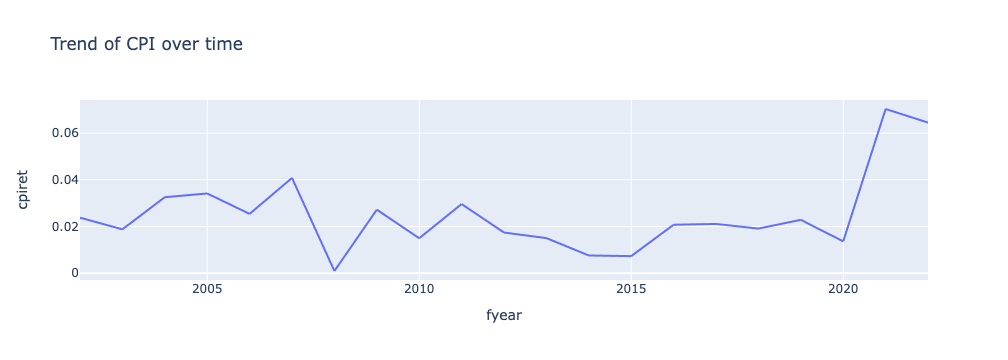

In [82]:
# Graphing the trend of CPI over time
fig = px.line(df1, x='fyear', y='cpiret', title='Trend of CPI over time')
fig.show()

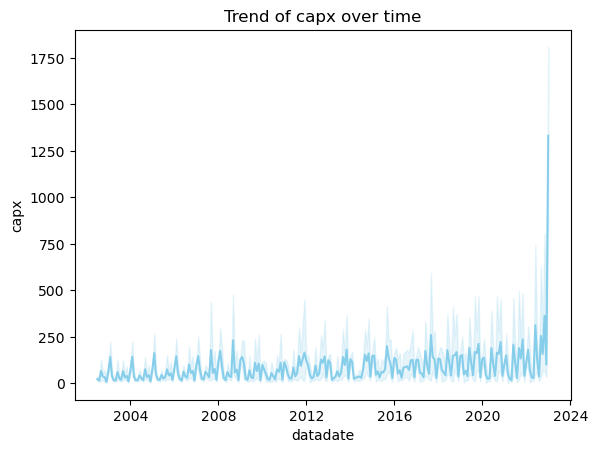

In [83]:
# Graphing the capx trend over time
sns.lineplot(data=df1, x='datadate', y='capx', color='skyblue')
plt.title('Trend of capx over time')
plt.show()

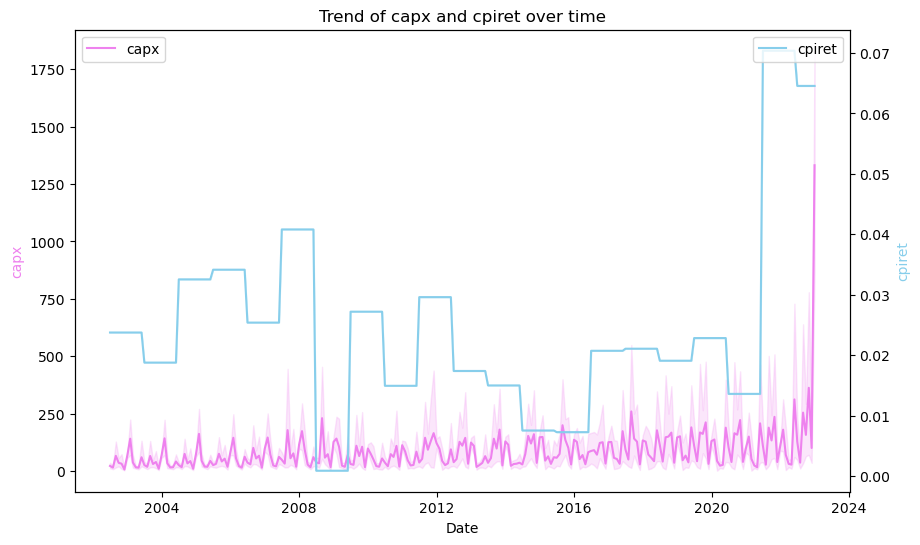

In [84]:
#Graphing the trend of capx and cpiret over time
# Creating a plot with two y-axes
fig, ax1 = plt.subplots(figsize=(10,6))
ax2 = ax1.twinx()

# First y-axis for capx
sns.lineplot(data=df1, x='datadate', y='capx', ax=ax1, color='violet', label='capx')

# Second y-axis for cpiret
sns.lineplot(data=df1, x='datadate', y='cpiret', ax=ax2, color='skyblue', label='cpiret')

# Setting x-axis label
ax1.set_xlabel('Date')

# Setting y-axis label for capx
ax1.set_ylabel('capx', color='violet')

# Setting y-axis label for cpiret
ax2.set_ylabel('cpiret', color='skyblue')

# Setting plot title
plt.title('Trend of capx and cpiret over time')

# Show legend
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Show plot
plt.show()

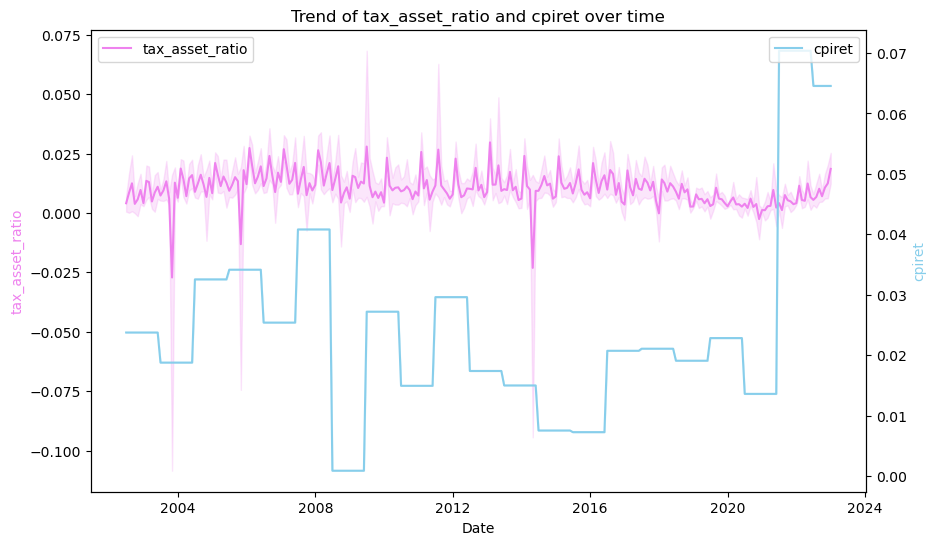

In [85]:
# Graphing the trend of tax_asset_ratio and cpiret over time
# Creating plot with two y-axes
fig, ax1 = plt.subplots(figsize=(10,6))
ax2 = ax1.twinx()

# First y-axis for capx
sns.lineplot(data=df1, x='datadate', y='tax_asset_ratio', ax=ax1, color='violet', label='tax_asset_ratio')

# Second y-axis for cpiret
sns.lineplot(data=df1, x='datadate', y='cpiret', ax=ax2, color='skyblue', label='cpiret')

# Setting x-axis label
ax1.set_xlabel('Date')

# Setting y-axis label for capx
ax1.set_ylabel('tax_asset_ratio', color='violet')

# Setting y-axis label for cpiret
ax2.set_ylabel('cpiret', color='skyblue')

# Setting plot title
plt.title('Trend of tax_asset_ratio and cpiret over time')

# Show legend
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Show plot
plt.show()

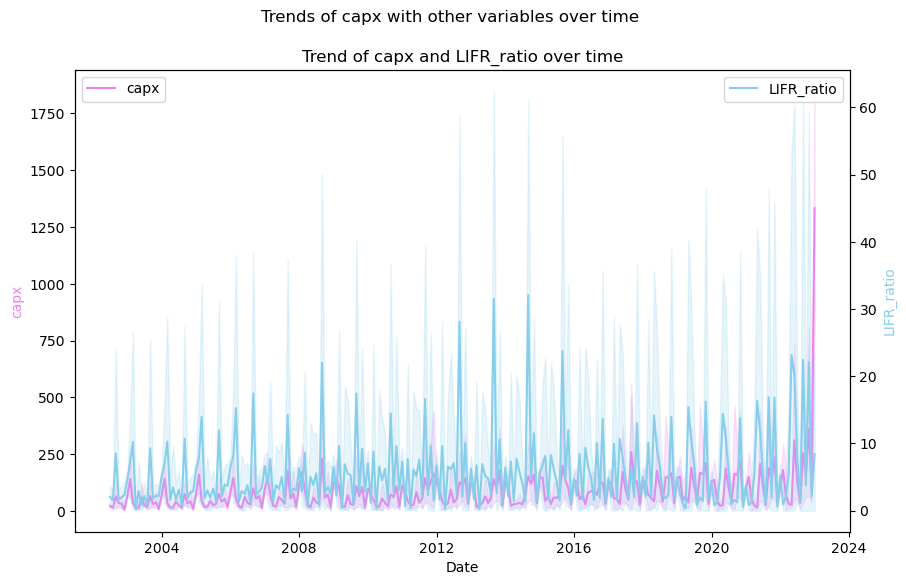

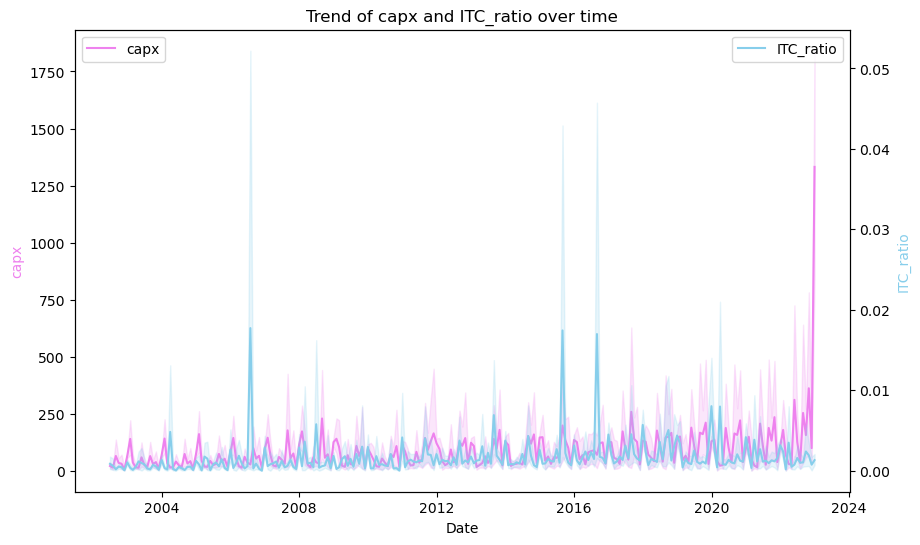

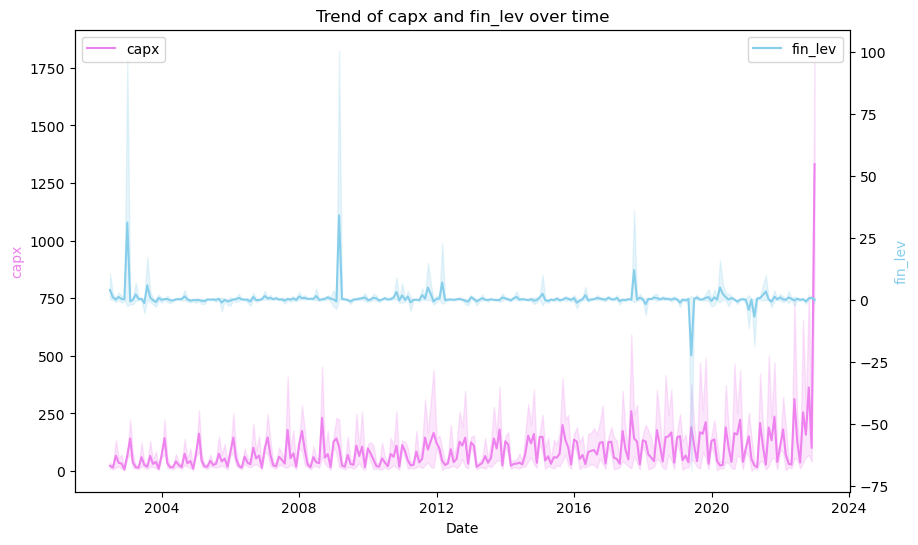

In [86]:
# Graphing the trends of capx with other variables over time
# Creating plot 1 with two y-axes
fig, ax1 = plt.subplots(figsize=(10,6))
ax2 = ax1.twinx()

sns.lineplot(data=df1, x='datadate', y='capx', ax=ax1, color='violet', label='capx')
sns.lineplot(data=df1, x='datadate', y='LIFR_ratio', ax=ax2, color='skyblue', label='LIFR_ratio')

ax1.set_xlabel('Date')
ax1.set_ylabel('capx', color='violet')
ax2.set_ylabel('LIFR_ratio', color='skyblue')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
ax1.set_title('Trend of capx and LIFR_ratio over time')

# Creating plot 2 with two y-axes
fig2, ax3 = plt.subplots(figsize=(10,6))
ax4 = ax3.twinx()

sns.lineplot(data=df1, x='datadate', y='capx', ax=ax3, color='violet', label='capx')
sns.lineplot(data=df1, x='datadate', y='ITC_ratio', ax=ax4, color='skyblue', label='ITC_ratio')

ax3.set_xlabel('Date')
ax3.set_ylabel('capx', color='violet')
ax4.set_ylabel('ITC_ratio', color='skyblue')
ax3.legend(loc='upper left')
ax4.legend(loc='upper right')
ax3.set_title('Trend of capx and ITC_ratio over time')

# Creating plot 3 with two y-axes
fig3, ax5 = plt.subplots(figsize=(10,6))
ax6 = ax5.twinx()

sns.lineplot(data=df1, x='datadate', y='capx', ax=ax5, color='violet', label='capx')
sns.lineplot(data=df1, x='datadate', y='fin_lev', ax=ax6, color='skyblue', label='fin_lev')

ax5.set_xlabel('Date')
ax5.set_ylabel('capx', color='violet')
ax6.set_ylabel('fin_lev', color='skyblue')
ax5.legend(loc='upper left')
ax6.legend(loc='upper right')
ax5.set_title('Trend of capx and fin_lev over time')

# Setting the overall title
fig.suptitle('Trends of capx with other variables over time')

plt.show()


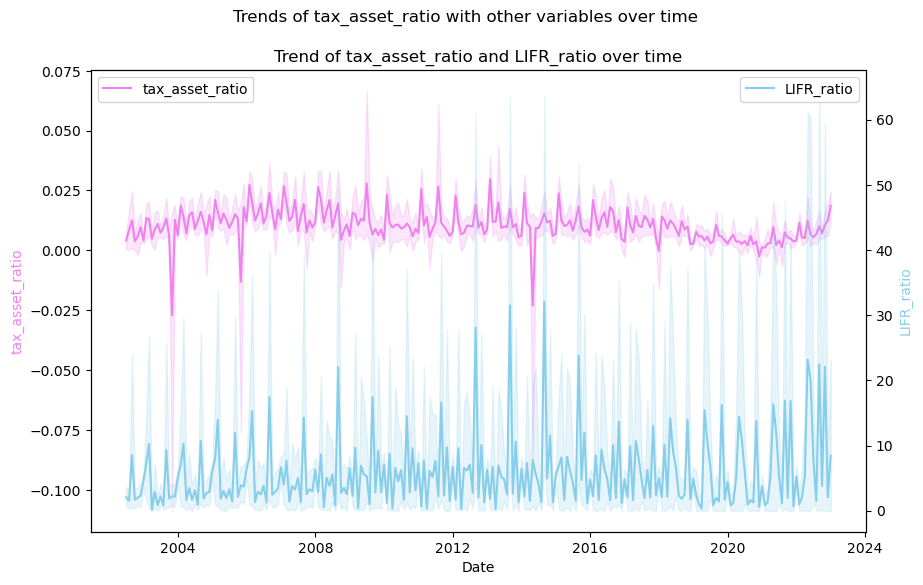

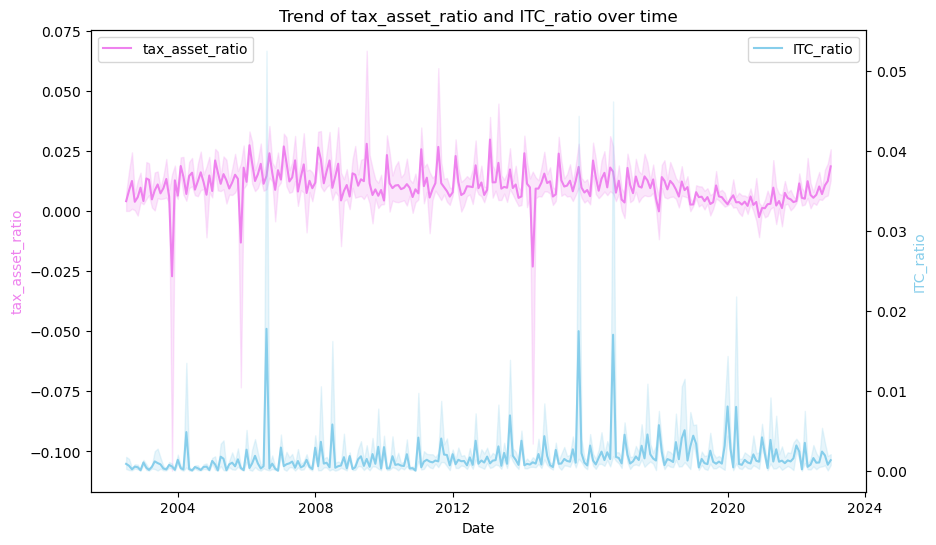

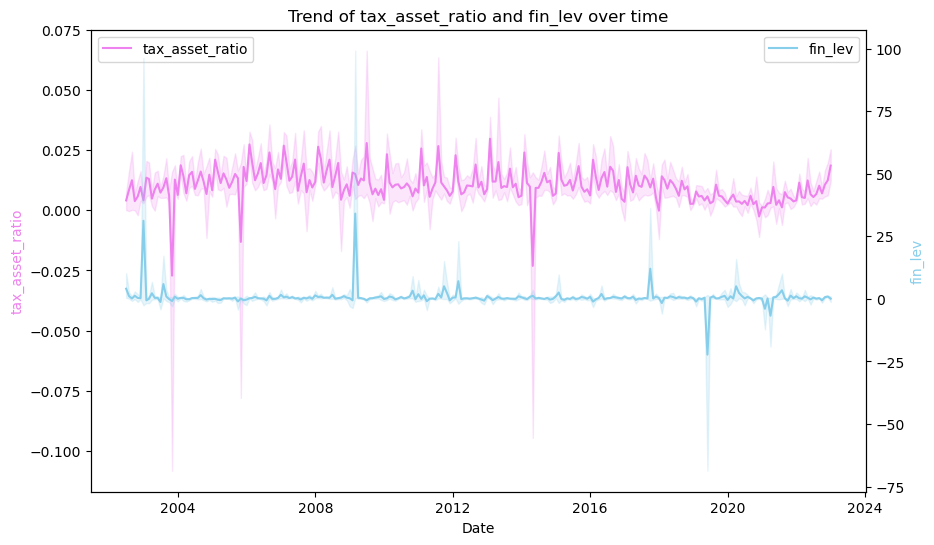

In [87]:
# Graphing the trends of tax_asset_ratio with other variables over time
# Creating plot 1 with two y-axes
fig, ax1 = plt.subplots(figsize=(10,6))
ax2 = ax1.twinx()

sns.lineplot(data=df1, x='datadate', y='tax_asset_ratio', ax=ax1, color='violet', label='tax_asset_ratio')
sns.lineplot(data=df1, x='datadate', y='LIFR_ratio', ax=ax2, color='skyblue', label='LIFR_ratio')

ax1.set_xlabel('Date')
ax1.set_ylabel('tax_asset_ratio', color='violet')
ax2.set_ylabel('LIFR_ratio', color='skyblue')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
ax1.set_title('Trend of tax_asset_ratio and LIFR_ratio over time')

# Creating plot 2 with two y-axes
fig2, ax3 = plt.subplots(figsize=(10,6))
ax4 = ax3.twinx()

sns.lineplot(data=df1, x='datadate', y='tax_asset_ratio', ax=ax3, color='violet', label='tax_asset_ratio')
sns.lineplot(data=df1, x='datadate', y='ITC_ratio', ax=ax4, color='skyblue', label='ITC_ratio')

ax3.set_xlabel('Date')
ax3.set_ylabel('tax_asset_ratio', color='violet')
ax4.set_ylabel('ITC_ratio', color='skyblue')
ax3.legend(loc='upper left')
ax4.legend(loc='upper right')
ax3.set_title('Trend of tax_asset_ratio and ITC_ratio over time')

# Creating plot 3 with two y-axes
fig3, ax5 = plt.subplots(figsize=(10,6))
ax6 = ax5.twinx()

sns.lineplot(data=df1, x='datadate', y='tax_asset_ratio', ax=ax5, color='violet', label='tax_asset_ratio')
sns.lineplot(data=df1, x='datadate', y='fin_lev', ax=ax6, color='skyblue', label='fin_lev')

ax5.set_xlabel('Date')
ax5.set_ylabel('tax_asset_ratio', color='violet')
ax6.set_ylabel('fin_lev', color='skyblue')
ax5.legend(loc='upper left')
ax6.legend(loc='upper right')
ax5.set_title('Trend of tax_asset_ratio and fin_lev over time')

# Setting the overall title
fig.suptitle('Trends of tax_asset_ratio with other variables over time')

plt.show()


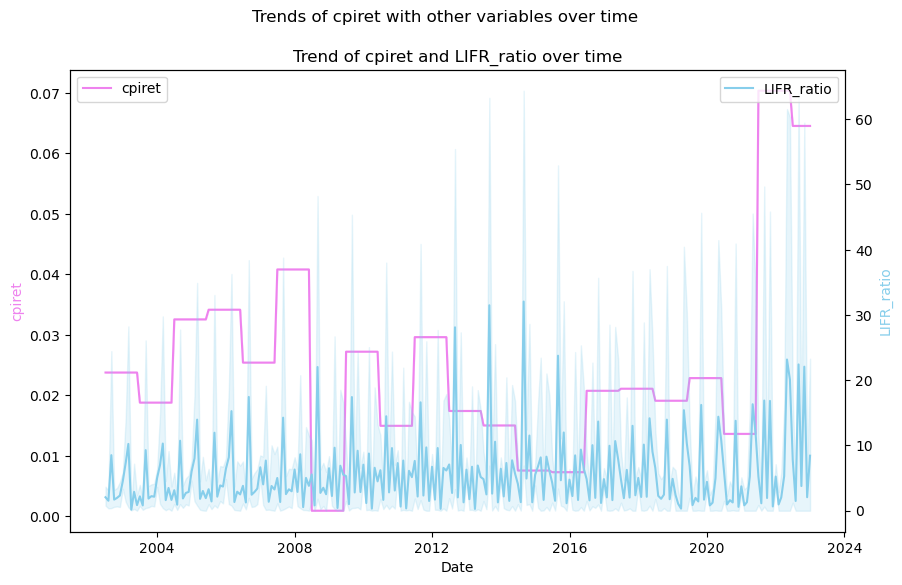

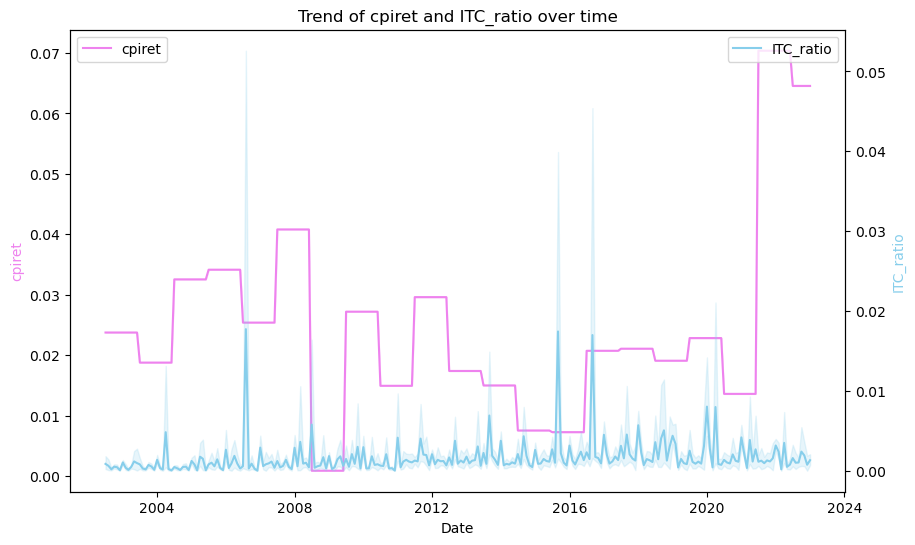

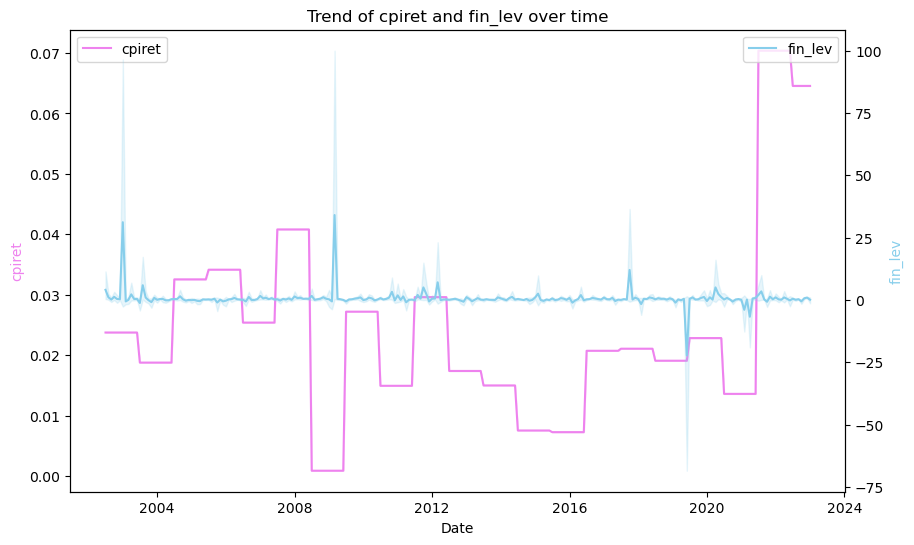

In [88]:
# Graphing the trends of cpiret with other variables over time
# Creating plot 1 with two y-axes
fig, ax1 = plt.subplots(figsize=(10,6))
ax2 = ax1.twinx()

sns.lineplot(data=df1, x='datadate', y='cpiret', ax=ax1, color='violet', label='cpiret')
sns.lineplot(data=df1, x='datadate', y='LIFR_ratio', ax=ax2, color='skyblue', label='LIFR_ratio')

ax1.set_xlabel('Date')
ax1.set_ylabel('cpiret', color='violet')
ax2.set_ylabel('LIFR_ratio', color='skyblue')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
ax1.set_title('Trend of cpiret and LIFR_ratio over time')

# Creating plot 2 with two y-axes
fig2, ax3 = plt.subplots(figsize=(10,6))
ax4 = ax3.twinx()

sns.lineplot(data=df1, x='datadate', y='cpiret', ax=ax3, color='violet', label='cpiret')
sns.lineplot(data=df1, x='datadate', y='ITC_ratio', ax=ax4, color='skyblue', label='ITC_ratio')

ax3.set_xlabel('Date')
ax3.set_ylabel('cpiret', color='violet')
ax4.set_ylabel('ITC_ratio', color='skyblue')
ax3.legend(loc='upper left')
ax4.legend(loc='upper right')
ax3.set_title('Trend of cpiret and ITC_ratio over time')

# Creating plot 3 with two y-axes
fig3, ax5 = plt.subplots(figsize=(10,6))
ax6 = ax5.twinx()

sns.lineplot(data=df1, x='datadate', y='cpiret', ax=ax5, color='violet', label='cpiret')
sns.lineplot(data=df1, x='datadate', y='fin_lev', ax=ax6, color='skyblue', label='fin_lev')

ax5.set_xlabel('Date')
ax5.set_ylabel('cpiret', color='violet')
ax6.set_ylabel('fin_lev', color='skyblue')
ax5.legend(loc='upper left')
ax6.legend(loc='upper right')
ax5.set_title('Trend of cpiret and fin_lev over time')

# Setting the overall title
fig.suptitle('Trends of cpiret with other variables over time')

plt.show()
